In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from getdist import plots, MCSamples
import pandas as pd
import re
import seaborn as sns
from tqdm import tqdm


from sbi.neural_nets import posterior_nn
from sbi.analysis import pairplot, sbc_rank_plot
from sbi.inference import NPE, SNPE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

from sbi.diagnostics import check_sbc, check_tarp, run_sbc, run_tarp


seed= 555
np.random.seed(seed); 
torch.manual_seed(seed)


/Users/karla/venvs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Useful plot and file merger functions

num_posterior_samples = 100
num_sbc_samples = 1000
parameter_labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$", r"$\theta_4$"]

def plot_pretty(dpi=200, fontsize=12):
    plt.rc("savefig", dpi=dpi)       
    plt.rc('text', usetex=False)     
    plt.rc('font', size=fontsize)    
    plt.rc('xtick', direction='in')  
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10)
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10)
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) 
    return

plot_pretty()

def merge_txt_files(file1_path, file2_path, output_path):
    try:
        with open(file1_path, 'r') as file1, open(file2_path, 'r') as file2:
            content1 = file1.read()
            content2 = file2.read()

        with open(output_path, 'w') as output_file:
            output_file.write(content1)
            output_file.write("\n") 
            output_file.write(content2)

        print(f"Files merged successfully into {output_path}")

    except Exception as e:
        print(f"An error occurred: {e}")

merge_txt_files("all_param_throws_1.txt", "all_param_throws_2.txt", 'merged_output.txt')

Files merged successfully into merged_output.txt


In [3]:
# Setting Priors

# Normalzed range for better performance in training
X1_range = (0,1)
X2_range = (0,1)
X3_range = (0,1)
X4_range = (0,1)

low = torch.tensor([min(X1_range), min(X2_range), min(X3_range), min(X4_range)])
high = torch.tensor([max(X1_range), max(X2_range), max(X3_range), max(X4_range)])
prior = BoxUniform(low=low, high=high)

sample = prior.sample((2,))
print(sample)


tensor([[0.7655, 0.4534, 0.2509, 0.1968],
        [0.7848, 0.0297, 0.7133, 0.8326]])


In [4]:
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

In [5]:
# Load data and devide between thetas and x (histograms 58 bins)

file='merged_output.txt'
with open(file, mode="r") as file:
    param = list(csv.reader(file))
theta = []
x = []
numbers_ar=[]
for i in range(len(param)):
    numbers = re.findall(r'[-+]?\d*\.\d+e[+-]?\d+|\d+\.\d+|\d+', param[i][0])
    numbers_array = [float(num) for num in numbers]
    numbers_ar.append(numbers_array)
    theta.append(numbers_array[:4])
    x.append(numbers_array[4:62])

print("################### thetas before maping ##########################")
theta1 = [theta[i][0] for i in range(len(theta))]
theta2 = [theta[i][1] for i in range(len(theta))]
theta3 = [theta[i][2] for i in range(len(theta))]
theta4 = [theta[i][3] for i in range(len(theta))]
print("max", max(theta1), max(theta2), max(theta3), max(theta4))
print("min", min(theta1), min(theta2), min(theta3), min(theta4))
print("####################################################################")

theta = torch.tensor(theta, dtype=torch.float32)
theta_or = theta
theta_min = theta.min(dim=0).values
theta_max = theta.max(dim=0).values
# Normalize theta between [0,1]
theta = (theta - theta_min) / (theta_max - theta_min)

print("################### thetas after maping ##########################")
print(theta[:,0].min(), theta[:,0].max())
print(theta[:,1].min(), theta[:,1].max())
print(theta[:,2].min(), theta[:,2].max())
print(theta[:,3].min(), theta[:,3].max())
print("####################################################################")


theta = torch.tensor(theta[20000:])
theta_test = torch.tensor(theta[:20000])
x = torch.tensor(x[20000:])
x_test = torch.tensor(x[:20000])


################### thetas before maping ##########################
max 14.9999 3.99997 0.999996 0.999995
min 7.0869e-05 -8.20886e-05 4.38304e-06 -9.8089e-05
####################################################################
################### thetas after maping ##########################
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
####################################################################


/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2219308788.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta[20000:])
/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2219308788.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta_test = torch.tensor(theta[:20000])
/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2219308788.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x[:20000])


In [6]:
print("theta.shape", theta.shape)
print("x.shape", x.shape)
print("theta test.shape", theta_test.shape)
print("x test.shape", x_test.shape)

theta.shape torch.Size([195525, 4])
x.shape torch.Size([195525, 58])
theta test.shape torch.Size([20000, 4])
x test.shape torch.Size([20000, 58])


In [7]:
# Custom embedding network for x (58D → nD) n < 58
class EmbeddingNet(nn.Module):
    def __init__(self, input_dim=58, output_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 45),
            nn.ReLU(),
            nn.Linear(45, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
        )

    def forward(self, x):
        return self.net(x)


In [8]:
embedding_net = EmbeddingNet(input_dim=58, output_dim=24) #16

posterior_nn = posterior_nn(model="maf", embedding_net=embedding_net, hidden_features=55, num_transforms=6)

# Subsample (example)
# N = 10000
mask = x.sum(dim=1) < 1e-30  # remove outliers
theta_sub = theta[mask]#[:N]
x_sub = x[mask]#[:N]
x_t = x_sub / x_sub.max()
print(x_t)


print(len(x_t))

inference = NPE(prior=prior, density_estimator=posterior_nn)
density_estimator = inference.append_simulations(theta_sub, x_t).train(
    training_batch_size=256*2,     
    stop_after_epochs=45,
    learning_rate=1e-2,  
    validation_fraction=0.1
)



tensor([[0.0997, 0.1248, 0.0891,  ..., 0.1382, 0.1537, 0.1390],
        [0.0985, 0.1103, 0.1101,  ..., 0.1459, 0.1847, 0.1653],
        [0.0705, 0.0851, 0.0674,  ..., 0.1121, 0.1212, 0.1084],
        ...,
        [0.1180, 0.1638, 0.0989,  ..., 0.1467, 0.1721, 0.1668],
        [0.1452, 0.1604, 0.1546,  ..., 0.2226, 0.2582, 0.2268],
        [0.0841, 0.1026, 0.0834,  ..., 0.1205, 0.1447, 0.1324]])
195405
 Neural network successfully converged after 215 epochs.

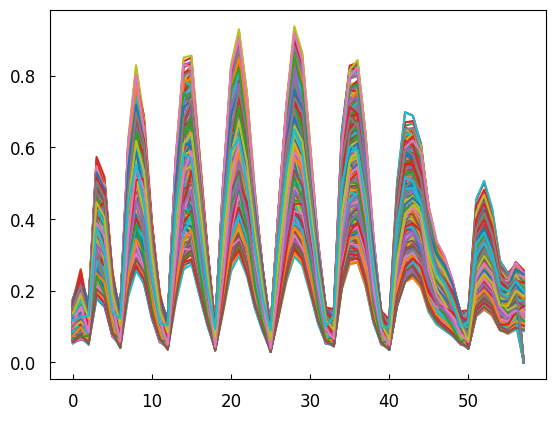

In [9]:
# Quich check for histogram outliers

for i in range(1000):
    plt.plot(x_t[i])

In [10]:
posterior = inference.build_posterior(density_estimator)

print(posterior) # prints how the posterior was trained

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [11]:
mask = x_test.sum(dim=1) < 1e-30  # only keep x with some signal
theta_sub_test = theta_test[mask]
x_sub_test = x_test[mask]
x_t_t = x_sub_test / x_sub.max()
log_prob = posterior.log_prob(theta_test[0], x=x_t_t[0])
print(f"log p(θ | x): {log_prob.item():.3f}")

log p(θ | x): 16.434


100%|██████████| 100000/100000 [00:00<00:00, 189341.57it/s]


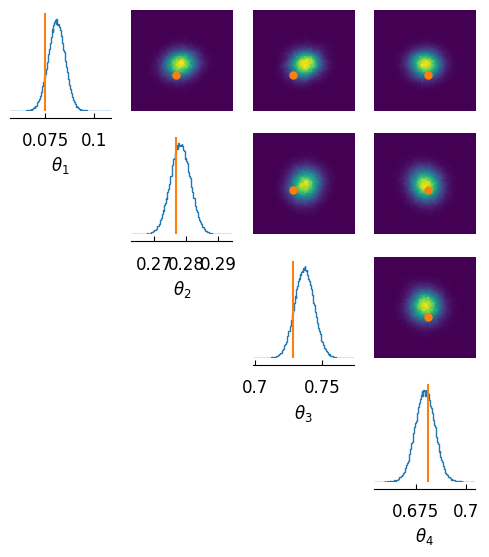

In [12]:
# Posterior fits for test event i
i=0
samples = posterior.sample((100000,), x=x_t_t[i])
pairplot(samples,
         points= theta_sub_test[i].reshape(1,4),
         figsize=(6, 6),
         labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$", r"$\theta_4$"]);

In [13]:
import gc

x_observed = torch.tensor(x_t_t, dtype=torch.float32)

def make_summary_statistic_array(x_observed, posterior, test_number = 1000):

  SBI_median_arr = []
  SBI_max_like_arr = []
  SBI_percentile68u_arr = []
  SBI_percentile68l_arr = []
  SBI_percentile95u_arr = []
  SBI_percentile95l_arr = []
  SBI_sample_array = []
  SBI_logp_array = []
  SBI_map_array = []

  for k in range(1):
    # This iterates over multiple SBI networks. If you only have one, len(posterior) should be 1.
    median_arr = []
    max_like_arr = []
    percentile68u_arr = []
    percentile68l_arr = []
    percentile95u_arr = []
    percentile95l_arr = []
    sample_array = []
    logp_array = []
    map_array = []
    for j in range(test_number):
      print(j)
      # This iterates over the number of images in the test set. If you only have one, test_number should be 1.
      median = []
      max_like = []
      percentile68u = []
      percentile68l = []
      percentile95u = []
      percentile95l = []
      samples = posterior.set_default_x(x_observed[j]).sample((1000,))
      # map = posterior[k].map(x=x_observed[j])
      # map_array.append(map.cpu().numpy())
      sample_array.append(samples.cpu())
      logp = posterior.log_prob(samples)
      logp_array.append(logp.cpu())
      argmaxlogp = torch.argmax(posterior.log_prob(samples))
      for i in range(len(samples[0])):
        # This iterates over the number of parameters per image.
        max_like.append(float(samples.cpu()[argmaxlogp][i]))
        median.append(np.median(samples.cpu()[:,i]))
        percentile68l.append(np.percentile(samples.cpu()[:,i],16))
        percentile68u.append(np.percentile(samples.cpu()[:,i],84))
        percentile95l.append(np.percentile(samples.cpu()[:,i],2.5))
        percentile95u.append(np.percentile(samples.cpu()[:,i],97.5))
      median_arr.append(median)
      max_like_arr.append(max_like)
      percentile68l_arr.append(percentile68l)
      percentile68u_arr.append(percentile68u)
      percentile95l_arr.append(percentile95l)
      percentile95u_arr.append(percentile95u)
    SBI_median_arr.append(median_arr)
    SBI_max_like_arr.append(max_like_arr)
    SBI_percentile68u_arr.append(percentile68u_arr)
    SBI_percentile68l_arr.append(percentile68l_arr)
    SBI_percentile95u_arr.append(percentile95u_arr)
    SBI_percentile95l_arr.append(percentile95l_arr)
    SBI_sample_array.append(sample_array)
    SBI_logp_array.append(logp_array)
    # SBI_map_array.append(map_array)

  SBI_median_arr = np.array(SBI_median_arr)
  SBI_max_like_arr = np.array(SBI_max_like_arr)
  SBI_percentile68u_arr = np.array(SBI_percentile68u_arr)
  SBI_percentile68l_arr = np.array(SBI_percentile68l_arr)
  SBI_percentile95u_arr = np.array(SBI_percentile95u_arr)
  SBI_percentile95l_arr = np.array(SBI_percentile95l_arr)
  # SBI_sample_array = np.array(SBI_sample_array)
  SBI_sample_array = SBI_sample_array
  SBI_logp_array = SBI_logp_array
  # SBI_map_array = np.array(SBI_map_array)

  return SBI_sample_array, SBI_logp_array, SBI_map_array, SBI_median_arr, SBI_max_like_arr, SBI_percentile68u_arr, SBI_percentile68l_arr, SBI_percentile95u_arr, SBI_percentile95l_arr

array_dump = make_summary_statistic_array(x_observed, posterior, 1000)

import pickle
file_name = f"4_parameter_npe_summary.pkl"
open_file = open(file_name, "wb")
pickle.dump(array_dump, open_file)
open_file.close()

/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2416906237.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_observed = torch.tensor(x_t_t, dtype=torch.float32)


0


100%|██████████| 1000/1000 [00:00<00:00, 105030.90it/s]


1


100%|██████████| 1000/1000 [00:00<00:00, 126418.23it/s]


2


100%|██████████| 1000/1000 [00:00<00:00, 117645.69it/s]


3


1055it [00:00, 89111.12it/s]            


4


100%|██████████| 1000/1000 [00:00<00:00, 118654.11it/s]


5


100%|██████████| 1000/1000 [00:00<00:00, 115117.44it/s]


6


1037it [00:00, 96599.59it/s]            


7


100%|██████████| 1000/1000 [00:00<00:00, 126216.60it/s]


8


1087it [00:00, 97254.81it/s]            


9


100%|██████████| 1000/1000 [00:00<00:00, 105062.47it/s]


10


100%|██████████| 1000/1000 [00:00<00:00, 118242.67it/s]


11


100%|██████████| 1000/1000 [00:00<00:00, 121065.20it/s]


12


100%|██████████| 1000/1000 [00:00<00:00, 113777.78it/s]


13


100%|██████████| 1000/1000 [00:00<00:00, 120713.29it/s]


14


100%|██████████| 1000/1000 [00:00<00:00, 119444.80it/s]


15


100%|██████████| 1000/1000 [00:00<00:00, 106953.90it/s]


16


100%|██████████| 1000/1000 [00:00<00:00, 113960.17it/s]


17


100%|██████████| 1000/1000 [00:00<00:00, 117619.29it/s]


18


100%|██████████| 1000/1000 [00:00<00:00, 116592.65it/s]


19


1071it [00:00, 95804.89it/s]            


20


1095it [00:00, 93168.94it/s]            


21


1056it [00:00, 87919.03it/s]            


22


100%|██████████| 1000/1000 [00:00<00:00, 113821.00it/s]


23


100%|██████████| 1000/1000 [00:00<00:00, 117287.10it/s]


24


100%|██████████| 1000/1000 [00:00<00:00, 121686.90it/s]


25


1084it [00:00, 93199.11it/s]            


26


100%|██████████| 1000/1000 [00:00<00:00, 113124.15it/s]


27


100%|██████████| 1000/1000 [00:00<00:00, 118711.20it/s]


28


1226it [00:00, 68518.12it/s]            


29


1039it [00:00, 93788.48it/s]            


30


100%|██████████| 1000/1000 [00:00<00:00, 115848.75it/s]


31


1069it [00:00, 95132.95it/s]            


32


100%|██████████| 1000/1000 [00:00<00:00, 115539.20it/s]


33


100%|██████████| 1000/1000 [00:00<00:00, 113224.92it/s]


34


100%|██████████| 1000/1000 [00:00<00:00, 118192.69it/s]


35


100%|██████████| 1000/1000 [00:00<00:00, 113381.02it/s]


36


1101it [00:00, 89034.04it/s]            


37


100%|██████████| 1000/1000 [00:00<00:00, 121447.30it/s]


38


100%|██████████| 1000/1000 [00:00<00:00, 113482.25it/s]


39


100%|██████████| 1000/1000 [00:00<00:00, 120727.19it/s]


40


100%|██████████| 1000/1000 [00:00<00:00, 115807.17it/s]


41


100%|██████████| 1000/1000 [00:00<00:00, 115781.59it/s]


42


100%|██████████| 1000/1000 [00:00<00:00, 125315.33it/s]


43


100%|██████████| 1000/1000 [00:00<00:00, 123791.51it/s]


44


1033it [00:00, 90788.84it/s]            


45


100%|██████████| 1000/1000 [00:00<00:00, 115915.98it/s]


46


100%|██████████| 1000/1000 [00:00<00:00, 125184.42it/s]


47


100%|██████████| 1000/1000 [00:00<00:00, 110863.64it/s]


48


100%|██████████| 1000/1000 [00:00<00:00, 122058.73it/s]


49


100%|██████████| 1000/1000 [00:00<00:00, 115819.96it/s]


50


100%|██████████| 1000/1000 [00:00<00:00, 113728.42it/s]


51


100%|██████████| 1000/1000 [00:00<00:00, 109902.11it/s]


52


100%|██████████| 1000/1000 [00:00<00:00, 113845.72it/s]


53


100%|██████████| 1000/1000 [00:00<00:00, 114827.50it/s]


54


100%|██████████| 1000/1000 [00:00<00:00, 117273.98it/s]


55


100%|██████████| 1000/1000 [00:00<00:00, 114808.64it/s]


56


1084it [00:00, 95365.08it/s]            


57


100%|██████████| 1000/1000 [00:00<00:00, 118399.55it/s]


58


1058it [00:00, 93126.56it/s]            


59


1066it [00:00, 77906.43it/s]            


60


1034it [00:00, 88195.19it/s]            


61


100%|██████████| 1000/1000 [00:00<00:00, 118079.56it/s]


62


100%|██████████| 1000/1000 [00:00<00:00, 116644.53it/s]


63


1034it [00:00, 89537.14it/s]            


64


100%|██████████| 1000/1000 [00:00<00:00, 106101.64it/s]


65


100%|██████████| 1000/1000 [00:00<00:00, 108576.34it/s]


66


100%|██████████| 1000/1000 [00:00<00:00, 119417.59it/s]


67


100%|██████████| 1000/1000 [00:00<00:00, 111160.39it/s]


68


100%|██████████| 1000/1000 [00:00<00:00, 115663.46it/s]


69


100%|██████████| 1000/1000 [00:00<00:00, 113301.39it/s]


70


1155it [00:00, 75087.51it/s]            

71



1074it [00:00, 88490.21it/s]            


72


100%|██████████| 1000/1000 [00:00<00:00, 121405.12it/s]


73


100%|██████████| 1000/1000 [00:00<00:00, 104734.54it/s]


74


1099it [00:00, 84324.97it/s]            


75


100%|██████████| 1000/1000 [00:00<00:00, 102502.60it/s]


76


100%|██████████| 1000/1000 [00:00<00:00, 123108.42it/s]


77


100%|██████████| 1000/1000 [00:00<00:00, 121121.14it/s]


78


100%|██████████| 1000/1000 [00:00<00:00, 112968.76it/s]


79


100%|██████████| 1000/1000 [00:00<00:00, 115025.89it/s]


80


100%|██████████| 1000/1000 [00:00<00:00, 115114.28it/s]


81


100%|██████████| 1000/1000 [00:00<00:00, 116862.28it/s]


82


1064it [00:00, 86334.94it/s]            


83


1064it [00:00, 87091.44it/s]            


84


100%|██████████| 1000/1000 [00:00<00:00, 117028.57it/s]


85


100%|██████████| 1000/1000 [00:00<00:00, 115673.03it/s]


86


100%|██████████| 1000/1000 [00:00<00:00, 101284.78it/s]


87


100%|██████████| 1000/1000 [00:00<00:00, 108886.40it/s]


88


1055it [00:00, 82414.34it/s]            


89


100%|██████████| 1000/1000 [00:00<00:00, 114877.82it/s]


90


1078it [00:00, 88529.35it/s]            


91


100%|██████████| 1000/1000 [00:00<00:00, 119359.82it/s]


92


100%|██████████| 1000/1000 [00:00<00:00, 117136.43it/s]


93


1041it [00:00, 86196.24it/s]            


94


100%|██████████| 1000/1000 [00:00<00:00, 119075.18it/s]


95


1060it [00:00, 89249.47it/s]            


96


100%|██████████| 1000/1000 [00:00<00:00, 119102.23it/s]


97


100%|██████████| 1000/1000 [00:00<00:00, 109566.21it/s]


98


100%|██████████| 1000/1000 [00:00<00:00, 118259.34it/s]


99


1087it [00:00, 95518.81it/s]            


100


100%|██████████| 1000/1000 [00:00<00:00, 114733.27it/s]


101


100%|██████████| 1000/1000 [00:00<00:00, 114868.38it/s]


102


100%|██████████| 1000/1000 [00:00<00:00, 120235.75it/s]


103


100%|██████████| 1000/1000 [00:00<00:00, 112336.40it/s]


104


100%|██████████| 1000/1000 [00:00<00:00, 115861.55it/s]


105


1146it [00:00, 76110.34it/s]            


106


100%|██████████| 1000/1000 [00:00<00:00, 114115.20it/s]


107


100%|██████████| 1000/1000 [00:00<00:00, 113020.51it/s]


108


1094it [00:00, 96089.64it/s]            


109


100%|██████████| 1000/1000 [00:00<00:00, 111494.30it/s]


110


100%|██████████| 1000/1000 [00:00<00:00, 115304.16it/s]


111


100%|██████████| 1000/1000 [00:00<00:00, 108671.99it/s]


112


100%|██████████| 1000/1000 [00:00<00:00, 114836.93it/s]


113


100%|██████████| 1000/1000 [00:00<00:00, 116263.00it/s]


114


100%|██████████| 1000/1000 [00:00<00:00, 112741.02it/s]


115


100%|██████████| 1000/1000 [00:00<00:00, 100737.44it/s]


116


100%|██████████| 1000/1000 [00:00<00:00, 118946.85it/s]


117


100%|██████████| 1000/1000 [00:00<00:00, 122565.21it/s]


118


100%|██████████| 1000/1000 [00:00<00:00, 109543.32it/s]


119


100%|██████████| 1000/1000 [00:00<00:00, 104286.63it/s]


120


100%|██████████| 1000/1000 [00:00<00:00, 13619.68it/s]


121


100%|██████████| 1000/1000 [00:00<00:00, 60723.65it/s]


122


100%|██████████| 1000/1000 [00:00<00:00, 87780.00it/s]


123


100%|██████████| 1000/1000 [00:00<00:00, 76451.90it/s]


124


100%|██████████| 1000/1000 [00:00<00:00, 89191.17it/s]


125


1032it [00:00, 65080.77it/s]            


126


100%|██████████| 1000/1000 [00:00<00:00, 89767.66it/s]


127


100%|██████████| 1000/1000 [00:00<00:00, 112889.70it/s]


128


100%|██████████| 1000/1000 [00:00<00:00, 113543.69it/s]


129


100%|██████████| 1000/1000 [00:00<00:00, 117606.10it/s]


130


100%|██████████| 1000/1000 [00:00<00:00, 116037.85it/s]


131


100%|██████████| 1000/1000 [00:00<00:00, 111396.58it/s]


132


100%|██████████| 1000/1000 [00:00<00:00, 107262.97it/s]


133


100%|██████████| 1000/1000 [00:00<00:00, 112198.16it/s]


134


100%|██████████| 1000/1000 [00:00<00:00, 117711.72it/s]


135


100%|██████████| 1000/1000 [00:00<00:00, 119799.61it/s]


136


100%|██████████| 1000/1000 [00:00<00:00, 111157.45it/s]


137


100%|██████████| 1000/1000 [00:00<00:00, 114140.04it/s]


138


100%|██████████| 1000/1000 [00:00<00:00, 117632.49it/s]

139

100%|██████████| 1000/1000 [00:00<00:00, 113765.43it/s]


140


100%|██████████| 1000/1000 [00:00<00:00, 109346.26it/s]


141


100%|██████████| 1000/1000 [00:00<00:00, 104494.48it/s]


142


100%|██████████| 1000/1000 [00:00<00:00, 120163.41it/s]


143


100%|██████████| 1000/1000 [00:00<00:00, 116849.25it/s]


144


1063it [00:00, 86380.80it/s]            


145


100%|██████████| 1000/1000 [00:00<00:00, 113057.06it/s]


146


100%|██████████| 1000/1000 [00:00<00:00, 113790.12it/s]


147


100%|██████████| 1000/1000 [00:00<00:00, 122023.22it/s]


148


1038it [00:00, 89313.74it/s]            


149


100%|██████████| 1000/1000 [00:00<00:00, 107631.81it/s]


150


100%|██████████| 1000/1000 [00:00<00:00, 106144.60it/s]


151


100%|██████████| 1000/1000 [00:00<00:00, 110840.20it/s]


152


100%|██████████| 1000/1000 [00:00<00:00, 118162.72it/s]


153


100%|██████████| 1000/1000 [00:00<00:00, 99128.00it/s]


154


100%|██████████| 1000/1000 [00:00<00:00, 102690.82it/s]


155


100%|██████████| 1000/1000 [00:00<00:00, 109962.61it/s]


156


1070it [00:00, 84576.92it/s]            


157


100%|██████████| 1000/1000 [00:00<00:00, 104878.58it/s]


158


100%|██████████| 1000/1000 [00:00<00:00, 108954.28it/s]


159


100%|██████████| 1000/1000 [00:00<00:00, 106327.58it/s]


160


1069it [00:00, 93911.51it/s]            


161


100%|██████████| 1000/1000 [00:00<00:00, 120190.96it/s]


162


1061it [00:00, 86148.18it/s]            


163


1055it [00:00, 86087.64it/s]            


164


100%|██████████| 1000/1000 [00:00<00:00, 108483.67it/s]


165


100%|██████████| 1000/1000 [00:00<00:00, 112856.29it/s]


166


100%|██████████| 1000/1000 [00:00<00:00, 115221.80it/s]


167


100%|██████████| 1000/1000 [00:00<00:00, 117715.02it/s]


168


100%|██████████| 1000/1000 [00:00<00:00, 113907.56it/s]


169


100%|██████████| 1000/1000 [00:00<00:00, 115996.13it/s]


170


100%|██████████| 1000/1000 [00:00<00:00, 116797.19it/s]


171


100%|██████████| 1000/1000 [00:00<00:00, 105572.86it/s]


172


100%|██████████| 1000/1000 [00:00<00:00, 117883.75it/s]


173


100%|██████████| 1000/1000 [00:00<00:00, 114626.66it/s]


174


100%|██████████| 1000/1000 [00:00<00:00, 108812.95it/s]


175


100%|██████████| 1000/1000 [00:00<00:00, 112484.02it/s]


176


100%|██████████| 1000/1000 [00:00<00:00, 111627.83it/s]


177


100%|██████████| 1000/1000 [00:00<00:00, 112904.90it/s]


178


100%|██████████| 1000/1000 [00:00<00:00, 121037.26it/s]


179


100%|██████████| 1000/1000 [00:00<00:00, 105697.90it/s]


180


100%|██████████| 1000/1000 [00:00<00:00, 121247.19it/s]


181


100%|██████████| 1000/1000 [00:00<00:00, 113879.72it/s]


182


100%|██████████| 1000/1000 [00:00<00:00, 106915.73it/s]


183


1072it [00:00, 89088.45it/s]            


184


100%|██████████| 1000/1000 [00:00<00:00, 117592.91it/s]


185


100%|██████████| 1000/1000 [00:00<00:00, 109135.72it/s]


186


100%|██████████| 1000/1000 [00:00<00:00, 115996.13it/s]


187


100%|██████████| 1000/1000 [00:00<00:00, 113084.50it/s]


188


1085it [00:00, 92363.05it/s]            


189


100%|██████████| 1000/1000 [00:00<00:00, 105342.17it/s]


190


100%|██████████| 1000/1000 [00:00<00:00, 107098.64it/s]


191


100%|██████████| 1000/1000 [00:00<00:00, 107967.05it/s]


192


100%|██████████| 1000/1000 [00:00<00:00, 116359.76it/s]


193


1176it [00:00, 75743.64it/s]            


194


100%|██████████| 1000/1000 [00:00<00:00, 113249.38it/s]


195


100%|██████████| 1000/1000 [00:00<00:00, 111148.61it/s]


196


1094it [00:00, 76227.13it/s]            


197


100%|██████████| 1000/1000 [00:00<00:00, 112072.25it/s]


198


100%|██████████| 1000/1000 [00:00<00:00, 108321.17it/s]


199


1099it [00:00, 88479.95it/s]            


200


1048it [00:00, 82919.22it/s]            


201


1050it [00:00, 76401.63it/s]            


202


100%|██████████| 1000/1000 [00:00<00:00, 108494.89it/s]


203


100%|██████████| 1000/1000 [00:00<00:00, 106635.75it/s]


204


100%|██████████| 1000/1000 [00:00<00:00, 107309.62it/s]


205


100%|██████████| 1000/1000 [00:00<00:00, 119186.84it/s]


206


100%|██████████| 1000/1000 [00:00<00:00, 116414.67it/s]


207


1079it [00:00, 90330.61it/s]            


208


100%|██████████| 1000/1000 [00:00<00:00, 116589.41it/s]


209


100%|██████████| 1000/1000 [00:00<00:00, 106562.60it/s]


210


100%|██████████| 1000/1000 [00:00<00:00, 111770.61it/s]


211


100%|██████████| 1000/1000 [00:00<00:00, 99137.37it/s]


212


100%|██████████| 1000/1000 [00:00<00:00, 113648.30it/s]


213


100%|██████████| 1000/1000 [00:00<00:00, 115193.32it/s]


214


100%|██████████| 1000/1000 [00:00<00:00, 116963.30it/s]


215


100%|██████████| 1000/1000 [00:00<00:00, 106262.93it/s]


216


100%|██████████| 1000/1000 [00:00<00:00, 117080.84it/s]


217


1088it [00:00, 84251.58it/s]            


218


1056it [00:00, 88770.12it/s]            


219


100%|██████████| 1000/1000 [00:00<00:00, 114651.72it/s]


220


100%|██████████| 1000/1000 [00:00<00:00, 106690.00it/s]


221


100%|██████████| 1000/1000 [00:00<00:00, 95581.42it/s]


222


1088it [00:00, 80591.32it/s]            


223


100%|██████████| 1000/1000 [00:00<00:00, 110437.45it/s]


224


100%|██████████| 1000/1000 [00:00<00:00, 113466.90it/s]


225


100%|██████████| 1000/1000 [00:00<00:00, 110667.65it/s]


226


100%|██████████| 1000/1000 [00:00<00:00, 107169.79it/s]


227


100%|██████████| 1000/1000 [00:00<00:00, 116810.20it/s]


228


100%|██████████| 1000/1000 [00:00<00:00, 102555.23it/s]


229


1095it [00:00, 83919.80it/s]            


230


100%|██████████| 1000/1000 [00:00<00:00, 107689.84it/s]


231


100%|██████████| 1000/1000 [00:00<00:00, 115810.37it/s]


232


100%|██████████| 1000/1000 [00:00<00:00, 110591.78it/s]


233


100%|██████████| 1000/1000 [00:00<00:00, 109746.82it/s]


234


100%|██████████| 1000/1000 [00:00<00:00, 104820.91it/s]


235


100%|██████████| 1000/1000 [00:00<00:00, 117015.51it/s]


236


100%|██████████| 1000/1000 [00:00<00:00, 105416.31it/s]


237


1075it [00:00, 84912.93it/s]            


238


100%|██████████| 1000/1000 [00:00<00:00, 111494.30it/s]


239


100%|██████████| 1000/1000 [00:00<00:00, 94160.92it/s]


240


100%|██████████| 1000/1000 [00:00<00:00, 112907.94it/s]


241


1073it [00:00, 92025.11it/s]            


242


100%|██████████| 1000/1000 [00:00<00:00, 117451.32it/s]


243


100%|██████████| 1000/1000 [00:00<00:00, 96870.62it/s]


244


100%|██████████| 1000/1000 [00:00<00:00, 110034.73it/s]


245


100%|██████████| 1000/1000 [00:00<00:00, 101461.19it/s]


246


100%|██████████| 1000/1000 [00:00<00:00, 107653.91it/s]


247


100%|██████████| 1000/1000 [00:00<00:00, 105207.41it/s]


248


100%|██████████| 1000/1000 [00:00<00:00, 103061.75it/s]


249


1078it [00:00, 88389.17it/s]            


250


100%|██████████| 1000/1000 [00:00<00:00, 111010.35it/s]


251


100%|██████████| 1000/1000 [00:00<00:00, 104692.71it/s]


252


100%|██████████| 1000/1000 [00:00<00:00, 110182.15it/s]


253


100%|██████████| 1000/1000 [00:00<00:00, 113060.11it/s]


254


100%|██████████| 1000/1000 [00:00<00:00, 109078.96it/s]


255


1068it [00:00, 90814.51it/s]            


256


100%|██████████| 1000/1000 [00:00<00:00, 92395.73it/s]


257


1099it [00:00, 92382.96it/s]            


258


100%|██████████| 1000/1000 [00:00<00:00, 110975.10it/s]


259


100%|██████████| 1000/1000 [00:00<00:00, 117731.54it/s]


260


100%|██████████| 1000/1000 [00:00<00:00, 105474.63it/s]


261


100%|██████████| 1000/1000 [00:00<00:00, 114636.06it/s]


262


1098it [00:00, 92237.89it/s]            


263


100%|██████████| 1000/1000 [00:00<00:00, 101793.61it/s]


264


1099it [00:00, 85418.80it/s]            

265

100%|██████████| 1000/1000 [00:00<00:00, 101685.03it/s]


266


100%|██████████| 1000/1000 [00:00<00:00, 105943.52it/s]


267


100%|██████████| 1000/1000 [00:00<00:00, 114639.19it/s]


268


1088it [00:00, 93477.87it/s]            


269


100%|██████████| 1000/1000 [00:00<00:00, 121892.01it/s]


270


100%|██████████| 1000/1000 [00:00<00:00, 108756.52it/s]


271


100%|██████████| 1000/1000 [00:00<00:00, 92182.51it/s]


272


100%|██████████| 1000/1000 [00:00<00:00, 112246.21it/s]


273


100%|██████████| 1000/1000 [00:00<00:00, 113725.33it/s]


274


100%|██████████| 1000/1000 [00:00<00:00, 119731.21it/s]


275


100%|██████████| 1000/1000 [00:00<00:00, 113286.08it/s]


276


100%|██████████| 1000/1000 [00:00<00:00, 102796.53it/s]


277


100%|██████████| 1000/1000 [00:00<00:00, 108875.09it/s]


278


100%|██████████| 1000/1000 [00:00<00:00, 111743.81it/s]


279


100%|██████████| 1000/1000 [00:00<00:00, 16674.50it/s]


280


100%|██████████| 1000/1000 [00:00<00:00, 70008.91it/s]


281


100%|██████████| 1000/1000 [00:00<00:00, 87426.87it/s]


282


100%|██████████| 1000/1000 [00:00<00:00, 92038.88it/s]


283


1048it [00:00, 59803.68it/s]            


284


100%|██████████| 1000/1000 [00:00<00:00, 77742.84it/s]


285


1064it [00:00, 71804.79it/s]            


286


1081it [00:00, 82590.31it/s]            


287


100%|██████████| 1000/1000 [00:00<00:00, 102816.69it/s]


288


100%|██████████| 1000/1000 [00:00<00:00, 112006.41it/s]


289


1049it [00:00, 80579.92it/s]            


290


100%|██████████| 1000/1000 [00:00<00:00, 115845.55it/s]


291


100%|██████████| 1000/1000 [00:00<00:00, 103863.11it/s]


292


100%|██████████| 1000/1000 [00:00<00:00, 115130.08it/s]


293


1099it [00:00, 86421.31it/s]            


294


1067it [00:00, 90648.62it/s]            


295


100%|██████████| 1000/1000 [00:00<00:00, 94347.31it/s]


296


100%|██████████| 1000/1000 [00:00<00:00, 112108.20it/s]


297


100%|██████████| 1000/1000 [00:00<00:00, 105450.76it/s]


298


100%|██████████| 1000/1000 [00:00<00:00, 74095.15it/s]


299


100%|██████████| 1000/1000 [00:00<00:00, 106505.78it/s]


300


100%|██████████| 1000/1000 [00:00<00:00, 109483.27it/s]


301


1099it [00:00, 87597.20it/s]            


302


100%|██████████| 1000/1000 [00:00<00:00, 113008.33it/s]


303


100%|██████████| 1000/1000 [00:00<00:00, 101542.25it/s]


304


100%|██████████| 1000/1000 [00:00<00:00, 103509.39it/s]


305


100%|██████████| 1000/1000 [00:00<00:00, 98397.79it/s]


306


100%|██████████| 1000/1000 [00:00<00:00, 81779.44it/s]


307


100%|██████████| 1000/1000 [00:00<00:00, 99852.49it/s]


308


100%|██████████| 1000/1000 [00:00<00:00, 101771.38it/s]


309


100%|██████████| 1000/1000 [00:00<00:00, 103606.55it/s]


310


1318it [00:00, 62803.53it/s]            


311


100%|██████████| 1000/1000 [00:00<00:00, 109838.79it/s]


312


100%|██████████| 1000/1000 [00:00<00:00, 91257.89it/s]


313


1057it [00:00, 85810.11it/s]            


314


100%|██████████| 1000/1000 [00:00<00:00, 111806.37it/s]


315


100%|██████████| 1000/1000 [00:00<00:00, 105442.81it/s]


316


1095it [00:00, 86465.03it/s]            


317


100%|██████████| 1000/1000 [00:00<00:00, 113188.26it/s]


318


100%|██████████| 1000/1000 [00:00<00:00, 101328.82it/s]


319


100%|██████████| 1000/1000 [00:00<00:00, 114255.08it/s]


320


100%|██████████| 1000/1000 [00:00<00:00, 108332.36it/s]


321


100%|██████████| 1000/1000 [00:00<00:00, 110060.72it/s]


322


1099it [00:00, 94374.63it/s]            


323


100%|██████████| 1000/1000 [00:00<00:00, 113635.98it/s]


324


100%|██████████| 1000/1000 [00:00<00:00, 114654.86it/s]


325


100%|██████████| 1000/1000 [00:00<00:00, 88455.70it/s]


326


100%|██████████| 1000/1000 [00:00<00:00, 103509.39it/s]


327


1087it [00:00, 86141.45it/s]            


328


100%|██████████| 1000/1000 [00:00<00:00, 111794.45it/s]


329


100%|██████████| 1000/1000 [00:00<00:00, 100291.82it/s]


330


100%|██████████| 1000/1000 [00:00<00:00, 100885.24it/s]


331


100%|██████████| 1000/1000 [00:00<00:00, 108824.24it/s]


332


100%|██████████| 1000/1000 [00:00<00:00, 103476.19it/s]


333


1155it [00:00, 65940.10it/s]            


334


100%|██████████| 1000/1000 [00:00<00:00, 103158.07it/s]


335


100%|██████████| 1000/1000 [00:00<00:00, 72311.85it/s]


336


100%|██████████| 1000/1000 [00:00<00:00, 101011.58it/s]


337


100%|██████████| 1000/1000 [00:00<00:00, 104713.62it/s]


338


100%|██████████| 1000/1000 [00:00<00:00, 84331.35it/s]


339


100%|██████████| 1000/1000 [00:00<00:00, 106225.25it/s]


340


100%|██████████| 1000/1000 [00:00<00:00, 94419.52it/s]


341


100%|██████████| 1000/1000 [00:00<00:00, 109266.50it/s]


342


1042it [00:00, 83453.59it/s]            


343


100%|██████████| 1000/1000 [00:00<00:00, 107989.29it/s]


344


1079it [00:00, 63522.41it/s]            


345


100%|██████████| 1000/1000 [00:00<00:00, 111994.45it/s]


346


100%|██████████| 1000/1000 [00:00<00:00, 99433.50it/s]


347


100%|██████████| 1000/1000 [00:00<00:00, 102143.15it/s]


348


100%|██████████| 1000/1000 [00:00<00:00, 108979.76it/s]


349


1087it [00:00, 86898.34it/s]            


350


1062it [00:00, 82270.12it/s]            


351


100%|██████████| 1000/1000 [00:00<00:00, 104834.01it/s]


352


100%|██████████| 1000/1000 [00:00<00:00, 106273.70it/s]


353


100%|██████████| 1000/1000 [00:00<00:00, 105107.23it/s]


354


100%|██████████| 1000/1000 [00:00<00:00, 100069.28it/s]


355


100%|██████████| 1000/1000 [00:00<00:00, 98243.37it/s]


356


100%|██████████| 1000/1000 [00:00<00:00, 92326.58it/s]


357


100%|██████████| 1000/1000 [00:00<00:00, 115168.02it/s]


358


100%|██████████| 1000/1000 [00:00<00:00, 109600.56it/s]


359


1069it [00:00, 64280.75it/s]            


360


1035it [00:00, 76990.42it/s]            


361


100%|██████████| 1000/1000 [00:00<00:00, 104089.94it/s]


362


100%|██████████| 1000/1000 [00:00<00:00, 98038.99it/s]


363


1065it [00:00, 85557.05it/s]            


364


100%|██████████| 1000/1000 [00:00<00:00, 109158.44it/s]


365


100%|██████████| 1000/1000 [00:00<00:00, 101365.56it/s]


366


1038it [00:00, 81598.49it/s]            


367


100%|██████████| 1000/1000 [00:00<00:00, 107947.60it/s]


368


100%|██████████| 1000/1000 [00:00<00:00, 99088.19it/s]


369


100%|██████████| 1000/1000 [00:00<00:00, 119149.59it/s]


370


100%|██████████| 1000/1000 [00:00<00:00, 108590.39it/s]


371


100%|██████████| 1000/1000 [00:00<00:00, 103950.63it/s]


372


100%|██████████| 1000/1000 [00:00<00:00, 112547.40it/s]


373


100%|██████████| 1000/1000 [00:00<00:00, 103448.12it/s]


374


100%|██████████| 1000/1000 [00:00<00:00, 106077.49it/s]


375


100%|██████████| 1000/1000 [00:00<00:00, 103211.38it/s]


376


100%|██████████| 1000/1000 [00:00<00:00, 109698.03it/s]


377


100%|██████████| 1000/1000 [00:00<00:00, 107158.84it/s]


378


1098it [00:00, 91097.55it/s]            


379


100%|██████████| 1000/1000 [00:00<00:00, 102153.10it/s]


380


1094it [00:00, 83768.16it/s]            


381


100%|██████████| 1000/1000 [00:00<00:00, 106779.63it/s]


382


100%|██████████| 1000/1000 [00:00<00:00, 103262.20it/s]


383


100%|██████████| 1000/1000 [00:00<00:00, 90670.01it/s]


384


1048it [00:00, 79059.53it/s]            


385


100%|██████████| 1000/1000 [00:00<00:00, 99511.35it/s]


386


100%|██████████| 1000/1000 [00:00<00:00, 106711.72it/s]


387


100%|██████████| 1000/1000 [00:00<00:00, 102965.61it/s]


388


1041it [00:00, 85524.27it/s]            


389


100%|██████████| 1000/1000 [00:00<00:00, 101031.05it/s]


390


100%|██████████| 1000/1000 [00:00<00:00, 13373.63it/s]


391


100%|██████████| 1000/1000 [00:00<00:00, 61553.31it/s]


392


1042it [00:00, 68381.47it/s]            


393


100%|██████████| 1000/1000 [00:00<00:00, 78276.77it/s]


394


100%|██████████| 1000/1000 [00:00<00:00, 79644.23it/s]


395


100%|██████████| 1000/1000 [00:00<00:00, 54822.49it/s]


396


100%|██████████| 1000/1000 [00:00<00:00, 77268.78it/s]


397


100%|██████████| 1000/1000 [00:00<00:00, 77387.11it/s]


398


100%|██████████| 1000/1000 [00:00<00:00, 100229.50it/s]


399


100%|██████████| 1000/1000 [00:00<00:00, 107598.68it/s]


400


100%|██████████| 1000/1000 [00:00<00:00, 102796.53it/s]


401


100%|██████████| 1000/1000 [00:00<00:00, 93466.38it/s]


402


100%|██████████| 1000/1000 [00:00<00:00, 97685.07it/s]


403


100%|██████████| 1000/1000 [00:00<00:00, 100291.82it/s]


404


1099it [00:00, 85365.02it/s]            


405


100%|██████████| 1000/1000 [00:00<00:00, 98356.25it/s]


406


100%|██████████| 1000/1000 [00:00<00:00, 80840.03it/s]

407

100%|██████████| 1000/1000 [00:00<00:00, 106473.33it/s]


408


100%|██████████| 1000/1000 [00:00<00:00, 108296.00it/s]


409


1099it [00:00, 89627.46it/s]            


410


100%|██████████| 1000/1000 [00:00<00:00, 102041.26it/s]


411


100%|██████████| 1000/1000 [00:00<00:00, 76776.57it/s]


412


100%|██████████| 1000/1000 [00:00<00:00, 94002.64it/s]


413


1074it [00:00, 85537.90it/s]            


414


1079it [00:00, 80467.52it/s]            


415


100%|██████████| 1000/1000 [00:00<00:00, 99669.79it/s]


416


100%|██████████| 1000/1000 [00:00<00:00, 99186.61it/s]


417


100%|██████████| 1000/1000 [00:00<00:00, 100824.62it/s]


418


100%|██████████| 1000/1000 [00:00<00:00, 102145.63it/s]


419


100%|██████████| 1000/1000 [00:00<00:00, 104066.69it/s]


420


1097it [00:00, 85649.03it/s]            


421


100%|██████████| 1000/1000 [00:00<00:00, 83099.95it/s]


422


100%|██████████| 1000/1000 [00:00<00:00, 85199.86it/s]


423


100%|██████████| 1000/1000 [00:00<00:00, 96589.54it/s]


424


100%|██████████| 1000/1000 [00:00<00:00, 101882.63it/s]


425


100%|██████████| 1000/1000 [00:00<00:00, 103606.55it/s]


426


1047it [00:00, 84164.22it/s]            


427


100%|██████████| 1000/1000 [00:00<00:00, 107980.95it/s]


428


100%|██████████| 1000/1000 [00:00<00:00, 103842.54it/s]


429


100%|██████████| 1000/1000 [00:00<00:00, 106861.25it/s]


430


100%|██████████| 1000/1000 [00:00<00:00, 102063.61it/s]


431


100%|██████████| 1000/1000 [00:00<00:00, 80684.52it/s]


432


1035it [00:00, 83855.29it/s]            


433


100%|██████████| 1000/1000 [00:00<00:00, 107334.34it/s]


434


100%|██████████| 1000/1000 [00:00<00:00, 98873.29it/s]


435


100%|██████████| 1000/1000 [00:00<00:00, 113713.00it/s]


436


100%|██████████| 1000/1000 [00:00<00:00, 119332.65it/s]


437


1057it [00:00, 81306.13it/s]            


438


1099it [00:00, 87794.07it/s]            


439


100%|██████████| 1000/1000 [00:00<00:00, 102292.61it/s]


440


100%|██████████| 1000/1000 [00:00<00:00, 95374.95it/s]


441


100%|██████████| 1000/1000 [00:00<00:00, 83872.66it/s]


442


100%|██████████| 1000/1000 [00:00<00:00, 79169.18it/s]


443


100%|██████████| 1000/1000 [00:00<00:00, 96794.61it/s]


444


100%|██████████| 1000/1000 [00:00<00:00, 90744.55it/s]


445


100%|██████████| 1000/1000 [00:00<00:00, 86912.37it/s]


446


1096it [00:00, 81419.72it/s]            


447


100%|██████████| 1000/1000 [00:00<00:00, 104439.84it/s]


448


100%|██████████| 1000/1000 [00:00<00:00, 112309.32it/s]


449


100%|██████████| 1000/1000 [00:00<00:00, 109121.52it/s]


450


100%|██████████| 1000/1000 [00:00<00:00, 106896.65it/s]


451


1074it [00:00, 71347.74it/s]            


452


100%|██████████| 1000/1000 [00:00<00:00, 95119.72it/s]


453


100%|██████████| 1000/1000 [00:00<00:00, 101810.91it/s]


454


1070it [00:00, 79395.42it/s]            

455



100%|██████████| 1000/1000 [00:00<00:00, 110583.04it/s]


456


100%|██████████| 1000/1000 [00:00<00:00, 110682.25it/s]


457


100%|██████████| 1000/1000 [00:00<00:00, 100373.42it/s]


458


100%|██████████| 1000/1000 [00:00<00:00, 112750.11it/s]


459


100%|██████████| 1000/1000 [00:00<00:00, 78106.22it/s]


460


100%|██████████| 1000/1000 [00:00<00:00, 82493.59it/s]


461


100%|██████████| 1000/1000 [00:00<00:00, 84158.75it/s]


462


100%|██████████| 1000/1000 [00:00<00:00, 98261.78it/s]


463


100%|██████████| 1000/1000 [00:00<00:00, 95483.51it/s]


464


100%|██████████| 1000/1000 [00:00<00:00, 100071.67it/s]


465


100%|██████████| 1000/1000 [00:00<00:00, 113072.30it/s]


466


100%|██████████| 1000/1000 [00:00<00:00, 97446.77it/s]


467


100%|██████████| 1000/1000 [00:00<00:00, 101009.15it/s]


468


100%|██████████| 1000/1000 [00:00<00:00, 87268.61it/s]


469


1098it [00:00, 80716.24it/s]            


470


100%|██████████| 1000/1000 [00:00<00:00, 89639.12it/s]


471


100%|██████████| 1000/1000 [00:00<00:00, 99997.71it/s]


472


100%|██████████| 1000/1000 [00:00<00:00, 100455.15it/s]


473


100%|██████████| 1000/1000 [00:00<00:00, 119994.96it/s]


474


100%|██████████| 1000/1000 [00:00<00:00, 97342.74it/s]


475


100%|██████████| 1000/1000 [00:00<00:00, 98794.11it/s]


476


100%|██████████| 1000/1000 [00:00<00:00, 100019.17it/s]


477


100%|██████████| 1000/1000 [00:00<00:00, 112877.55it/s]


478


100%|██████████| 1000/1000 [00:00<00:00, 99433.50it/s]


479


100%|██████████| 1000/1000 [00:00<00:00, 119475.42it/s]


480


100%|██████████| 1000/1000 [00:00<00:00, 94964.66it/s]


481


100%|██████████| 1000/1000 [00:00<00:00, 89293.71it/s]


482


100%|██████████| 1000/1000 [00:00<00:00, 98726.67it/s]


483


100%|██████████| 1000/1000 [00:00<00:00, 107606.96it/s]


484


1094it [00:00, 84780.38it/s]            


485


100%|██████████| 1000/1000 [00:00<00:00, 104776.40it/s]


486


100%|██████████| 1000/1000 [00:00<00:00, 117698.51it/s]


487


1097it [00:00, 12663.21it/s]            


488


100%|██████████| 1000/1000 [00:00<00:00, 63035.27it/s]


489


100%|██████████| 1000/1000 [00:00<00:00, 89798.41it/s]


490


1097it [00:00, 63447.53it/s]            


491


100%|██████████| 1000/1000 [00:00<00:00, 77251.70it/s]


492


100%|██████████| 1000/1000 [00:00<00:00, 84560.88it/s]


493


1039it [00:00, 59822.39it/s]            


494


100%|██████████| 1000/1000 [00:00<00:00, 105328.95it/s]


495


100%|██████████| 1000/1000 [00:00<00:00, 84680.38it/s]


496


100%|██████████| 1000/1000 [00:00<00:00, 108556.67it/s]


497


1065it [00:00, 88661.30it/s]            


498


1029it [00:00, 82649.15it/s]            

499

100%|██████████| 1000/1000 [00:00<00:00, 117316.63it/s]


500


1095it [00:00, 73200.77it/s]            


501


100%|██████████| 1000/1000 [00:00<00:00, 96434.08it/s]


502


100%|██████████| 1000/1000 [00:00<00:00, 107134.20it/s]


503


100%|██████████| 1000/1000 [00:00<00:00, 114495.24it/s]


504


100%|██████████| 1000/1000 [00:00<00:00, 104320.35it/s]


505


100%|██████████| 1000/1000 [00:00<00:00, 99032.04it/s]


506


100%|██████████| 1000/1000 [00:00<00:00, 97580.53it/s]


507


100%|██████████| 1000/1000 [00:00<00:00, 102310.08it/s]


508


100%|██████████| 1000/1000 [00:00<00:00, 98443.98it/s]


509


100%|██████████| 1000/1000 [00:00<00:00, 97247.95it/s]


510


100%|██████████| 1000/1000 [00:00<00:00, 99442.93it/s]


511


1045it [00:00, 82621.07it/s]            


512


100%|██████████| 1000/1000 [00:00<00:00, 97464.89it/s]


513


1040it [00:00, 77571.46it/s]            


514


100%|██████████| 1000/1000 [00:00<00:00, 99629.54it/s]


515


100%|██████████| 1000/1000 [00:00<00:00, 105865.97it/s]


516


100%|██████████| 1000/1000 [00:00<00:00, 96338.84it/s]


517


100%|██████████| 1000/1000 [00:00<00:00, 115130.08it/s]


518


100%|██████████| 1000/1000 [00:00<00:00, 109147.08it/s]


519


100%|██████████| 1000/1000 [00:00<00:00, 108486.47it/s]


520


1055it [00:00, 70493.07it/s]            


521


100%|██████████| 1000/1000 [00:00<00:00, 100848.86it/s]


522


100%|██████████| 1000/1000 [00:00<00:00, 117480.93it/s]


523


100%|██████████| 1000/1000 [00:00<00:00, 118734.72it/s]


524


100%|██████████| 1000/1000 [00:00<00:00, 101917.29it/s]


525


1052it [00:00, 77571.25it/s]            


526


100%|██████████| 1000/1000 [00:00<00:00, 104330.73it/s]


527


100%|██████████| 1000/1000 [00:00<00:00, 114598.47it/s]


528


100%|██████████| 1000/1000 [00:00<00:00, 88787.13it/s]


529


100%|██████████| 1000/1000 [00:00<00:00, 97753.37it/s]


530


100%|██████████| 1000/1000 [00:00<00:00, 107515.93it/s]


531


100%|██████████| 1000/1000 [00:00<00:00, 109706.63it/s]


532


100%|██████████| 1000/1000 [00:00<00:00, 93958.42it/s]


533


100%|██████████| 1000/1000 [00:00<00:00, 97933.69it/s]


534


100%|██████████| 1000/1000 [00:00<00:00, 98929.26it/s]


535


100%|██████████| 1000/1000 [00:00<00:00, 108846.84it/s]


536


100%|██████████| 1000/1000 [00:00<00:00, 99402.87it/s]


537


100%|██████████| 1000/1000 [00:00<00:00, 103274.91it/s]


538


100%|██████████| 1000/1000 [00:00<00:00, 93712.80it/s]


539


100%|██████████| 1000/1000 [00:00<00:00, 103791.15it/s]


540


1039it [00:00, 71496.95it/s]            


541


100%|██████████| 1000/1000 [00:00<00:00, 105186.31it/s]


542


100%|██████████| 1000/1000 [00:00<00:00, 112907.94it/s]


543


1060it [00:00, 78536.69it/s]            


544


1098it [00:00, 82641.19it/s]            


545


100%|██████████| 1000/1000 [00:00<00:00, 97265.99it/s]


546


100%|██████████| 1000/1000 [00:00<00:00, 99570.41it/s]


547


100%|██████████| 1000/1000 [00:00<00:00, 106679.15it/s]


548


100%|██████████| 1000/1000 [00:00<00:00, 97951.99it/s]


549


100%|██████████| 1000/1000 [00:00<00:00, 108646.65it/s]


550


100%|██████████| 1000/1000 [00:00<00:00, 102009.00it/s]


551


1062it [00:00, 90498.80it/s]            


552


100%|██████████| 1000/1000 [00:00<00:00, 105509.12it/s]


553


100%|██████████| 1000/1000 [00:00<00:00, 96052.03it/s]


554


100%|██████████| 1000/1000 [00:00<00:00, 108131.27it/s]


555


100%|██████████| 1000/1000 [00:00<00:00, 125266.67it/s]


556


100%|██████████| 1000/1000 [00:00<00:00, 122040.97it/s]


557


100%|██████████| 1000/1000 [00:00<00:00, 102965.61it/s]


558


100%|██████████| 1000/1000 [00:00<00:00, 109277.89it/s]


559


100%|██████████| 1000/1000 [00:00<00:00, 103950.63it/s]


560


1093it [00:00, 77206.61it/s]            


561


100%|██████████| 1000/1000 [00:00<00:00, 104844.49it/s]


562


100%|██████████| 1000/1000 [00:00<00:00, 108804.48it/s]


563


100%|██████████| 1000/1000 [00:00<00:00, 113805.56it/s]


564


100%|██████████| 1000/1000 [00:00<00:00, 107123.26it/s]


565


100%|██████████| 1000/1000 [00:00<00:00, 120616.09it/s]


566


100%|██████████| 1000/1000 [00:00<00:00, 113057.06it/s]


567


100%|██████████| 1000/1000 [00:00<00:00, 106863.97it/s]


568


100%|██████████| 1000/1000 [00:00<00:00, 106098.96it/s]

569



1055it [00:00, 13668.30it/s]            


570


100%|██████████| 1000/1000 [00:00<00:00, 64231.30it/s]


571


100%|██████████| 1000/1000 [00:00<00:00, 92241.30it/s]


572


100%|██████████| 1000/1000 [00:00<00:00, 70671.86it/s]


573


100%|██████████| 1000/1000 [00:00<00:00, 76161.75it/s]


574


100%|██████████| 1000/1000 [00:00<00:00, 48215.93it/s]


575


100%|██████████| 1000/1000 [00:00<00:00, 96299.02it/s]


576


100%|██████████| 1000/1000 [00:00<00:00, 110347.38it/s]


577


100%|██████████| 1000/1000 [00:00<00:00, 97903.97it/s]


578


100%|██████████| 1000/1000 [00:00<00:00, 109155.60it/s]


579


100%|██████████| 1000/1000 [00:00<00:00, 103714.15it/s]


580


1239it [00:00, 58614.95it/s]            


581


100%|██████████| 1000/1000 [00:00<00:00, 111821.27it/s]


582


100%|██████████| 1000/1000 [00:00<00:00, 90770.08it/s]


583


100%|██████████| 1000/1000 [00:00<00:00, 104965.19it/s]


584


100%|██████████| 1000/1000 [00:00<00:00, 102680.77it/s]


585


100%|██████████| 1000/1000 [00:00<00:00, 93031.03it/s]


586


100%|██████████| 1000/1000 [00:00<00:00, 105331.59it/s]


587


100%|██████████| 1000/1000 [00:00<00:00, 103104.82it/s]


588


100%|██████████| 1000/1000 [00:00<00:00, 119943.49it/s]


589


100%|██████████| 1000/1000 [00:00<00:00, 105120.40it/s]


590


100%|██████████| 1000/1000 [00:00<00:00, 100785.85it/s]


591


1085it [00:00, 84944.56it/s]            


592


1069it [00:00, 85617.66it/s]            


593


100%|██████████| 1000/1000 [00:00<00:00, 93206.76it/s]


594


100%|██████████| 1000/1000 [00:00<00:00, 101287.23it/s]


595


100%|██████████| 1000/1000 [00:00<00:00, 83050.59it/s]


596


100%|██████████| 1000/1000 [00:00<00:00, 107609.72it/s]


597


100%|██████████| 1000/1000 [00:00<00:00, 107689.84it/s]


598


100%|██████████| 1000/1000 [00:00<00:00, 98647.73it/s]


599


100%|██████████| 1000/1000 [00:00<00:00, 111705.12it/s]


600


100%|██████████| 1000/1000 [00:00<00:00, 114535.88it/s]


601


100%|██████████| 1000/1000 [00:00<00:00, 105719.21it/s]


602


100%|██████████| 1000/1000 [00:00<00:00, 92489.45it/s]


603


100%|██████████| 1000/1000 [00:00<00:00, 93493.47it/s]


604


1056it [00:00, 76169.58it/s]            


605


100%|██████████| 1000/1000 [00:00<00:00, 102322.56it/s]


606


100%|██████████| 1000/1000 [00:00<00:00, 112285.27it/s]


607


100%|██████████| 1000/1000 [00:00<00:00, 102145.63it/s]


608


100%|██████████| 1000/1000 [00:00<00:00, 105695.23it/s]


609


1090it [00:00, 81930.28it/s]            


610


100%|██████████| 1000/1000 [00:00<00:00, 97915.40it/s]


611


100%|██████████| 1000/1000 [00:00<00:00, 101719.55it/s]


612


100%|██████████| 1000/1000 [00:00<00:00, 111136.83it/s]


613


100%|██████████| 1000/1000 [00:00<00:00, 121718.68it/s]


614


1092it [00:00, 81182.96it/s]            


615


100%|██████████| 1000/1000 [00:00<00:00, 111210.50it/s]


616


100%|██████████| 1000/1000 [00:00<00:00, 111532.84it/s]


617


100%|██████████| 1000/1000 [00:00<00:00, 93811.32it/s]


618


100%|██████████| 1000/1000 [00:00<00:00, 103757.77it/s]


619


100%|██████████| 1000/1000 [00:00<00:00, 91430.96it/s]


620


100%|██████████| 1000/1000 [00:00<00:00, 86416.35it/s]


621


1091it [00:00, 75591.15it/s]            


622


100%|██████████| 1000/1000 [00:00<00:00, 93562.29it/s]


623


100%|██████████| 1000/1000 [00:00<00:00, 83591.84it/s]


624


1046it [00:00, 83460.00it/s]            


625


100%|██████████| 1000/1000 [00:00<00:00, 119946.92it/s]


626


100%|██████████| 1000/1000 [00:00<00:00, 127030.83it/s]


627


100%|██████████| 1000/1000 [00:00<00:00, 44523.63it/s]


628


100%|██████████| 1000/1000 [00:00<00:00, 86623.38it/s]


629


100%|██████████| 1000/1000 [00:00<00:00, 68241.12it/s]


630


100%|██████████| 1000/1000 [00:00<00:00, 65006.80it/s]


631


1106it [00:00, 57403.61it/s]            


632


1097it [00:00, 82854.37it/s]            


633


100%|██████████| 1000/1000 [00:00<00:00, 94481.20it/s]


634


100%|██████████| 1000/1000 [00:00<00:00, 95309.93it/s]


635


1056it [00:00, 82915.59it/s]            


636


100%|██████████| 1000/1000 [00:00<00:00, 113830.27it/s]


637


100%|██████████| 1000/1000 [00:00<00:00, 105772.53it/s]


638


100%|██████████| 1000/1000 [00:00<00:00, 100078.84it/s]


639


100%|██████████| 1000/1000 [00:00<00:00, 96476.23it/s]


640


100%|██████████| 1000/1000 [00:00<00:00, 92626.30it/s]


641


100%|██████████| 1000/1000 [00:00<00:00, 88804.05it/s]


642


100%|██████████| 1000/1000 [00:00<00:00, 93223.33it/s]


643


100%|██████████| 1000/1000 [00:00<00:00, 75735.43it/s]


644


100%|██████████| 1000/1000 [00:00<00:00, 79499.31it/s]


645


100%|██████████| 1000/1000 [00:00<00:00, 103883.69it/s]


646


100%|██████████| 1000/1000 [00:00<00:00, 104273.67it/s]


647


100%|██████████| 1000/1000 [00:00<00:00, 106747.02it/s]


648


100%|██████████| 1000/1000 [00:00<00:00, 99950.05it/s]


649


100%|██████████| 1000/1000 [00:00<00:00, 105708.55it/s]


650


100%|██████████| 1000/1000 [00:00<00:00, 90992.60it/s]


651


100%|██████████| 1000/1000 [00:00<00:00, 87123.59it/s]


652


100%|██████████| 1000/1000 [00:00<00:00, 108875.09it/s]


653


1037it [00:00, 85909.13it/s]            


654


100%|██████████| 1000/1000 [00:00<00:00, 89677.45it/s]


655


100%|██████████| 1000/1000 [00:00<00:00, 111396.58it/s]


656


1035it [00:00, 80764.74it/s]            


657


100%|██████████| 1000/1000 [00:00<00:00, 106872.14it/s]


658


1082it [00:00, 78794.31it/s]            


659


100%|██████████| 1000/1000 [00:00<00:00, 121761.08it/s]


660


100%|██████████| 1000/1000 [00:00<00:00, 108954.28it/s]


661


100%|██████████| 1000/1000 [00:00<00:00, 97865.14it/s]


662


100%|██████████| 1000/1000 [00:00<00:00, 108270.84it/s]


663


1039it [00:00, 79414.70it/s]            


664


100%|██████████| 1000/1000 [00:00<00:00, 96870.62it/s]


665


100%|██████████| 1000/1000 [00:00<00:00, 81182.70it/s]


666


100%|██████████| 1000/1000 [00:00<00:00, 76751.28it/s]


667


100%|██████████| 1000/1000 [00:00<00:00, 97408.30it/s]


668


1115it [00:00, 74343.45it/s]            


669


1111it [00:00, 71565.92it/s]            


670


1095it [00:00, 76258.81it/s]            


671


100%|██████████| 1000/1000 [00:00<00:00, 102392.50it/s]


672


1046it [00:00, 78059.25it/s]            


673


100%|██████████| 1000/1000 [00:00<00:00, 94775.82it/s]


674


100%|██████████| 1000/1000 [00:00<00:00, 117359.30it/s]


675


100%|██████████| 1000/1000 [00:00<00:00, 106440.91it/s]


676


100%|██████████| 1000/1000 [00:00<00:00, 102510.12it/s]


677


100%|██████████| 1000/1000 [00:00<00:00, 114623.52it/s]


678


100%|██████████| 1000/1000 [00:00<00:00, 107587.64it/s]


679


100%|██████████| 1000/1000 [00:00<00:00, 106690.00it/s]


680


100%|██████████| 1000/1000 [00:00<00:00, 107549.01it/s]


681


100%|██████████| 1000/1000 [00:00<00:00, 111821.27it/s]


682


100%|██████████| 1000/1000 [00:00<00:00, 117136.43it/s]


683


100%|██████████| 1000/1000 [00:00<00:00, 80230.77it/s]


684


100%|██████████| 1000/1000 [00:00<00:00, 102846.94it/s]


685


1066it [00:00, 78107.86it/s]            


686


1045it [00:00, 73538.60it/s]            


687


100%|██████████| 1000/1000 [00:00<00:00, 106986.63it/s]


688


100%|██████████| 1000/1000 [00:00<00:00, 109027.92it/s]


689


100%|██████████| 1000/1000 [00:00<00:00, 110289.35it/s]


690


1070it [00:00, 76768.82it/s]            


691


100%|██████████| 1000/1000 [00:00<00:00, 56902.01it/s]


692


100%|██████████| 1000/1000 [00:00<00:00, 54743.06it/s]


693


100%|██████████| 1000/1000 [00:00<00:00, 89327.94it/s]


694


100%|██████████| 1000/1000 [00:00<00:00, 84789.94it/s]


695


100%|██████████| 1000/1000 [00:00<00:00, 67095.98it/s]


696


1050it [00:00, 68718.31it/s]            


697


100%|██████████| 1000/1000 [00:00<00:00, 88753.31it/s]


698


100%|██████████| 1000/1000 [00:00<00:00, 82107.63it/s]


699


100%|██████████| 1000/1000 [00:00<00:00, 111172.18it/s]


700


100%|██████████| 1000/1000 [00:00<00:00, 117827.46it/s]


701


100%|██████████| 1000/1000 [00:00<00:00, 85653.98it/s]


702


100%|██████████| 1000/1000 [00:00<00:00, 119051.52it/s]


703


100%|██████████| 1000/1000 [00:00<00:00, 107967.05it/s]


704


100%|██████████| 1000/1000 [00:00<00:00, 111222.30it/s]


705


100%|██████████| 1000/1000 [00:00<00:00, 117093.91it/s]


706


100%|██████████| 1000/1000 [00:00<00:00, 96647.40it/s]


707


100%|██████████| 1000/1000 [00:00<00:00, 87312.21it/s]


708


100%|██████████| 1000/1000 [00:00<00:00, 110109.84it/s]


709


100%|██████████| 1000/1000 [00:00<00:00, 111423.21it/s]


710


100%|██████████| 1000/1000 [00:00<00:00, 124290.40it/s]


711


100%|██████████| 1000/1000 [00:00<00:00, 135466.18it/s]


712


100%|██████████| 1000/1000 [00:00<00:00, 95858.85it/s]


713


100%|██████████| 1000/1000 [00:00<00:00, 86265.28it/s]


714


100%|██████████| 1000/1000 [00:00<00:00, 97182.60it/s]


715


100%|██████████| 1000/1000 [00:00<00:00, 101606.20it/s]


716


100%|██████████| 1000/1000 [00:00<00:00, 114311.13it/s]


717


1036it [00:00, 89134.34it/s]            


718


100%|██████████| 1000/1000 [00:00<00:00, 96237.16it/s]


719


100%|██████████| 1000/1000 [00:00<00:00, 109827.28it/s]


720


100%|██████████| 1000/1000 [00:00<00:00, 101996.60it/s]


721


100%|██████████| 1000/1000 [00:00<00:00, 96749.95it/s]


722


1099it [00:00, 77297.18it/s]            


723


100%|██████████| 1000/1000 [00:00<00:00, 101830.68it/s]


724


1232it [00:00, 60707.74it/s]            


725


100%|██████████| 1000/1000 [00:00<00:00, 67636.97it/s]


726


100%|██████████| 1000/1000 [00:00<00:00, 96440.73it/s]


727


100%|██████████| 1000/1000 [00:00<00:00, 109429.00it/s]


728


100%|██████████| 1000/1000 [00:00<00:00, 108991.09it/s]


729


100%|██████████| 1000/1000 [00:00<00:00, 111036.80it/s]


730


1143it [00:00, 70421.57it/s]            


731


100%|██████████| 1000/1000 [00:00<00:00, 116102.09it/s]


732


100%|██████████| 1000/1000 [00:00<00:00, 103051.62it/s]


733


100%|██████████| 1000/1000 [00:00<00:00, 106804.10it/s]


734


1063it [00:00, 73208.52it/s]            


735


100%|██████████| 1000/1000 [00:00<00:00, 108979.76it/s]


736


100%|██████████| 1000/1000 [00:00<00:00, 128160.36it/s]


737


100%|██████████| 1000/1000 [00:00<00:00, 127972.66it/s]


738


100%|██████████| 1000/1000 [00:00<00:00, 123934.17it/s]


739


100%|██████████| 1000/1000 [00:00<00:00, 95629.37it/s]


740


100%|██████████| 1000/1000 [00:00<00:00, 104188.19it/s]


741


100%|██████████| 1000/1000 [00:00<00:00, 103412.41it/s]


742


1044it [00:00, 79282.53it/s]            


743


1095it [00:00, 80220.13it/s]            


744


1056it [00:00, 76185.30it/s]            


745


100%|██████████| 1000/1000 [00:00<00:00, 101823.27it/s]


746


1069it [00:00, 75853.68it/s]            


747


100%|██████████| 1000/1000 [00:00<00:00, 112207.17it/s]


748


100%|██████████| 1000/1000 [00:00<00:00, 62960.52it/s]


749


100%|██████████| 1000/1000 [00:00<00:00, 89206.35it/s]


750


1180it [00:00, 41026.21it/s]            


751


1060it [00:00, 64086.87it/s]            


752


100%|██████████| 1000/1000 [00:00<00:00, 76721.80it/s]


753


100%|██████████| 1000/1000 [00:00<00:00, 95950.95it/s]


754


100%|██████████| 1000/1000 [00:00<00:00, 105932.82it/s]


755


100%|██████████| 1000/1000 [00:00<00:00, 114457.74it/s]


756


1161it [00:00, 67201.94it/s]            


757


100%|██████████| 1000/1000 [00:00<00:00, 113814.83it/s]


758


100%|██████████| 1000/1000 [00:00<00:00, 110054.94it/s]


759


100%|██████████| 1000/1000 [00:00<00:00, 119247.83it/s]


760


100%|██████████| 1000/1000 [00:00<00:00, 121718.68it/s]


761


100%|██████████| 1000/1000 [00:00<00:00, 82081.92it/s]


762


100%|██████████| 1000/1000 [00:00<00:00, 105073.00it/s]


763


100%|██████████| 1000/1000 [00:00<00:00, 120598.75it/s]


764


1165it [00:00, 68175.80it/s]            


765


100%|██████████| 1000/1000 [00:00<00:00, 108657.91it/s]


766


100%|██████████| 1000/1000 [00:00<00:00, 115367.59it/s]

767

100%|██████████| 1000/1000 [00:00<00:00, 115676.22it/s]


768


1091it [00:00, 93496.22it/s]            


769


100%|██████████| 1000/1000 [00:00<00:00, 121065.20it/s]


770


1040it [00:00, 93416.34it/s]            


771


100%|██████████| 1000/1000 [00:00<00:00, 111782.53it/s]


772


100%|██████████| 1000/1000 [00:00<00:00, 110901.75it/s]


773


100%|██████████| 1000/1000 [00:00<00:00, 117028.57it/s]


774


100%|██████████| 1000/1000 [00:00<00:00, 99402.87it/s]


775


100%|██████████| 1000/1000 [00:00<00:00, 127536.84it/s]


776


1081it [00:00, 73996.19it/s]            


777


100%|██████████| 1000/1000 [00:00<00:00, 103061.75it/s]


778


100%|██████████| 1000/1000 [00:00<00:00, 109374.78it/s]


779


1085it [00:00, 91045.53it/s]            


780


100%|██████████| 1000/1000 [00:00<00:00, 104252.93it/s]


781


100%|██████████| 1000/1000 [00:00<00:00, 109902.11it/s]


782


100%|██████████| 1000/1000 [00:00<00:00, 102839.38it/s]


783


100%|██████████| 1000/1000 [00:00<00:00, 106738.87it/s]


784


100%|██████████| 1000/1000 [00:00<00:00, 100655.24it/s]


785


1098it [00:00, 83250.71it/s]            


786


100%|██████████| 1000/1000 [00:00<00:00, 95429.20it/s]


787


100%|██████████| 1000/1000 [00:00<00:00, 109073.28it/s]


788


100%|██████████| 1000/1000 [00:00<00:00, 129115.10it/s]


789


1047it [00:00, 85686.56it/s]            


790


100%|██████████| 1000/1000 [00:00<00:00, 129669.94it/s]


791


100%|██████████| 1000/1000 [00:00<00:00, 95603.21it/s]


792


100%|██████████| 1000/1000 [00:00<00:00, 92379.45it/s]


793


1059it [00:00, 78953.53it/s]            


794


1064it [00:00, 74645.23it/s]            


795


100%|██████████| 1000/1000 [00:00<00:00, 104865.46it/s]


796


1030it [00:00, 82538.22it/s]            


797


100%|██████████| 1000/1000 [00:00<00:00, 106279.08it/s]


798


100%|██████████| 1000/1000 [00:00<00:00, 105732.54it/s]


799


100%|██████████| 1000/1000 [00:00<00:00, 121401.60it/s]


800


100%|██████████| 1000/1000 [00:00<00:00, 76546.78it/s]


801


100%|██████████| 1000/1000 [00:00<00:00, 100747.12it/s]


802


1118it [00:00, 16231.33it/s]            


803


100%|██████████| 1000/1000 [00:00<00:00, 69969.21it/s]


804


1077it [00:00, 76550.85it/s]            


805


100%|██████████| 1000/1000 [00:00<00:00, 94152.46it/s]


806


100%|██████████| 1000/1000 [00:00<00:00, 59562.95it/s]


807


100%|██████████| 1000/1000 [00:00<00:00, 79624.57it/s]


808


100%|██████████| 1000/1000 [00:00<00:00, 79567.17it/s]


809


1051it [00:00, 83062.57it/s]            


810


100%|██████████| 1000/1000 [00:00<00:00, 101228.56it/s]


811


100%|██████████| 1000/1000 [00:00<00:00, 104015.08it/s]


812


100%|██████████| 1000/1000 [00:00<00:00, 118593.72it/s]


813


100%|██████████| 1000/1000 [00:00<00:00, 137875.28it/s]

814



100%|██████████| 1000/1000 [00:00<00:00, 85257.01it/s]


815


100%|██████████| 1000/1000 [00:00<00:00, 116715.94it/s]


816


100%|██████████| 1000/1000 [00:00<00:00, 105017.75it/s]


817


1145it [00:00, 71638.15it/s]            


818


100%|██████████| 1000/1000 [00:00<00:00, 76752.69it/s]


819


100%|██████████| 1000/1000 [00:00<00:00, 105743.20it/s]


820


100%|██████████| 1000/1000 [00:00<00:00, 101520.13it/s]


821


100%|██████████| 1000/1000 [00:00<00:00, 124886.23it/s]


822


100%|██████████| 1000/1000 [00:00<00:00, 86714.71it/s]


823


100%|██████████| 1000/1000 [00:00<00:00, 100241.48it/s]


824


100%|██████████| 1000/1000 [00:00<00:00, 125551.65it/s]


825


1063it [00:00, 86911.21it/s]            


826


100%|██████████| 1000/1000 [00:00<00:00, 114442.13it/s]


827


100%|██████████| 1000/1000 [00:00<00:00, 105318.37it/s]


828


100%|██████████| 1000/1000 [00:00<00:00, 125061.24it/s]


829


100%|██████████| 1000/1000 [00:00<00:00, 87395.90it/s]


830


100%|██████████| 1000/1000 [00:00<00:00, 82775.24it/s]


831


100%|██████████| 1000/1000 [00:00<00:00, 109371.93it/s]


832


100%|██████████| 1000/1000 [00:00<00:00, 105943.52it/s]


833


100%|██████████| 1000/1000 [00:00<00:00, 110011.65it/s]


834


1083it [00:00, 68691.50it/s]            


835


100%|██████████| 1000/1000 [00:00<00:00, 116901.36it/s]


836


1080it [00:00, 84146.31it/s]            


837


100%|██████████| 1000/1000 [00:00<00:00, 100181.62it/s]


838


100%|██████████| 1000/1000 [00:00<00:00, 103917.15it/s]


839


100%|██████████| 1000/1000 [00:00<00:00, 97846.87it/s]


840


100%|██████████| 1000/1000 [00:00<00:00, 116647.77it/s]


841


100%|██████████| 1000/1000 [00:00<00:00, 131875.62it/s]


842


100%|██████████| 1000/1000 [00:00<00:00, 87574.73it/s]


843


100%|██████████| 1000/1000 [00:00<00:00, 103606.55it/s]


844


100%|██████████| 1000/1000 [00:00<00:00, 117993.19it/s]


845


1099it [00:00, 64424.04it/s]            


846


1087it [00:00, 101913.64it/s]           


847


100%|██████████| 1000/1000 [00:00<00:00, 89022.69it/s]


848


100%|██████████| 1000/1000 [00:00<00:00, 118764.98it/s]


849


100%|██████████| 1000/1000 [00:00<00:00, 108005.97it/s]


850


100%|██████████| 1000/1000 [00:00<00:00, 123231.40it/s]


851


1040it [00:00, 70830.17it/s]            


852


100%|██████████| 1000/1000 [00:00<00:00, 92849.80it/s]


853


100%|██████████| 1000/1000 [00:00<00:00, 117800.98it/s]


854


100%|██████████| 1000/1000 [00:00<00:00, 90262.20it/s]


855


100%|██████████| 1000/1000 [00:00<00:00, 67991.12it/s]


856


1063it [00:00, 52397.99it/s]            


857


100%|██████████| 1000/1000 [00:00<00:00, 51077.17it/s]


858


100%|██████████| 1000/1000 [00:00<00:00, 60551.83it/s]


859


100%|██████████| 1000/1000 [00:00<00:00, 62251.27it/s]


860


100%|██████████| 1000/1000 [00:00<00:00, 60429.69it/s]


861


1070it [00:00, 78567.02it/s]            


862


100%|██████████| 1000/1000 [00:00<00:00, 108214.97it/s]


863


1046it [00:00, 78669.52it/s]            


864


100%|██████████| 1000/1000 [00:00<00:00, 92456.83it/s]


865


100%|██████████| 1000/1000 [00:00<00:00, 104219.26it/s]


866


100%|██████████| 1000/1000 [00:00<00:00, 112856.29it/s]


867


100%|██████████| 1000/1000 [00:00<00:00, 114470.24it/s]


868


100%|██████████| 1000/1000 [00:00<00:00, 116250.11it/s]


869


100%|██████████| 1000/1000 [00:00<00:00, 90679.81it/s]


870


100%|██████████| 1000/1000 [00:00<00:00, 98903.60it/s]


871


100%|██████████| 1000/1000 [00:00<00:00, 105873.99it/s]


872


100%|██████████| 1000/1000 [00:00<00:00, 106768.76it/s]


873


100%|██████████| 1000/1000 [00:00<00:00, 104007.34it/s]


874


100%|██████████| 1000/1000 [00:00<00:00, 113817.92it/s]


875


100%|██████████| 1000/1000 [00:00<00:00, 131979.36it/s]


876


100%|██████████| 1000/1000 [00:00<00:00, 91861.49it/s]


877


100%|██████████| 1000/1000 [00:00<00:00, 99610.61it/s]


878


100%|██████████| 1000/1000 [00:00<00:00, 112762.23it/s]


879


1088it [00:00, 77737.13it/s]            


880


100%|██████████| 1000/1000 [00:00<00:00, 100907.09it/s]


881


100%|██████████| 1000/1000 [00:00<00:00, 92123.79it/s]


882


100%|██████████| 1000/1000 [00:00<00:00, 107582.12it/s]


883


1159it [00:00, 68068.76it/s]            


884


1345it [00:00, 55733.44it/s]            


885


100%|██████████| 1000/1000 [00:00<00:00, 107213.62it/s]


886


100%|██████████| 1000/1000 [00:00<00:00, 110034.73it/s]


887


100%|██████████| 1000/1000 [00:00<00:00, 99118.63it/s]


888


100%|██████████| 1000/1000 [00:00<00:00, 103488.96it/s]


889


1254it [00:00, 64055.45it/s]            


890


100%|██████████| 1000/1000 [00:00<00:00, 103714.15it/s]


891


100%|██████████| 1000/1000 [00:00<00:00, 82109.24it/s]


892


1169it [00:00, 66876.83it/s]            


893


100%|██████████| 1000/1000 [00:00<00:00, 101613.59it/s]


894


100%|██████████| 1000/1000 [00:00<00:00, 109098.82it/s]


895


100%|██████████| 1000/1000 [00:00<00:00, 126121.72it/s]


896


1054it [00:00, 74571.06it/s]            


897


100%|██████████| 1000/1000 [00:00<00:00, 126311.63it/s]


898


100%|██████████| 1000/1000 [00:00<00:00, 83369.19it/s]


899


100%|██████████| 1000/1000 [00:00<00:00, 99919.10it/s]


900


1046it [00:00, 70102.78it/s]            


901


100%|██████████| 1000/1000 [00:00<00:00, 107806.10it/s]


902


100%|██████████| 1000/1000 [00:00<00:00, 114205.30it/s]


903


100%|██████████| 1000/1000 [00:00<00:00, 65897.41it/s]


904


100%|██████████| 1000/1000 [00:00<00:00, 86874.57it/s]


905


100%|██████████| 1000/1000 [00:00<00:00, 85395.88it/s]


906


100%|██████████| 1000/1000 [00:00<00:00, 43990.81it/s]


907


100%|██████████| 1000/1000 [00:00<00:00, 38337.41it/s]


908


100%|██████████| 1000/1000 [00:00<00:00, 58339.30it/s]


909


100%|██████████| 1000/1000 [00:00<00:00, 107180.74it/s]


910


100%|██████████| 1000/1000 [00:00<00:00, 100696.32it/s]


911


100%|██████████| 1000/1000 [00:00<00:00, 131946.14it/s]


912


100%|██████████| 1000/1000 [00:00<00:00, 84057.56it/s]


913


1088it [00:00, 75504.27it/s]            


914


1098it [00:00, 79859.64it/s]            


915


100%|██████████| 1000/1000 [00:00<00:00, 93385.23it/s]


916


100%|██████████| 1000/1000 [00:00<00:00, 103274.91it/s]


917


100%|██████████| 1000/1000 [00:00<00:00, 122881.20it/s]


918


100%|██████████| 1000/1000 [00:00<00:00, 88871.79it/s]


919


100%|██████████| 1000/1000 [00:00<00:00, 99539.69it/s]


920


100%|██████████| 1000/1000 [00:00<00:00, 89969.84it/s]


921


1086it [00:00, 77894.11it/s]            


922


100%|██████████| 1000/1000 [00:00<00:00, 121775.22it/s]


923


1091it [00:00, 97210.41it/s]            


924


100%|██████████| 1000/1000 [00:00<00:00, 107839.36it/s]


925


100%|██████████| 1000/1000 [00:00<00:00, 107689.84it/s]


926


100%|██████████| 1000/1000 [00:00<00:00, 114050.03it/s]


927


100%|██████████| 1000/1000 [00:00<00:00, 129282.25it/s]


928


1097it [00:00, 77818.11it/s]            


929


100%|██████████| 1000/1000 [00:00<00:00, 104515.31it/s]


930


100%|██████████| 1000/1000 [00:00<00:00, 89470.85it/s]


931


1098it [00:00, 75287.65it/s]            


932


100%|██████████| 1000/1000 [00:00<00:00, 97103.86it/s]


933


100%|██████████| 1000/1000 [00:00<00:00, 117910.27it/s]


934


100%|██████████| 1000/1000 [00:00<00:00, 123198.83it/s]


935


100%|██████████| 1000/1000 [00:00<00:00, 90155.49it/s]


936


100%|██████████| 1000/1000 [00:00<00:00, 99981.03it/s]


937


100%|██████████| 1000/1000 [00:00<00:00, 98183.57it/s]


938


100%|██████████| 1000/1000 [00:00<00:00, 112462.90it/s]


939


1097it [00:00, 74956.85it/s]            


940


100%|██████████| 1000/1000 [00:00<00:00, 103188.53it/s]


941


100%|██████████| 1000/1000 [00:00<00:00, 99610.61it/s]


942


100%|██████████| 1000/1000 [00:00<00:00, 97657.78it/s]


943


100%|██████████| 1000/1000 [00:00<00:00, 108742.42it/s]


944


100%|██████████| 1000/1000 [00:00<00:00, 107364.56it/s]


945


100%|██████████| 1000/1000 [00:00<00:00, 119230.88it/s]


946


100%|██████████| 1000/1000 [00:00<00:00, 57978.02it/s]


947


1036it [00:00, 77346.01it/s]            


948


100%|██████████| 1000/1000 [00:00<00:00, 113276.91it/s]


949


1085it [00:00, 27386.53it/s]            


950


100%|██████████| 1000/1000 [00:00<00:00, 42713.16it/s]


951


1068it [00:00, 43208.97it/s]            


952


100%|██████████| 1000/1000 [00:00<00:00, 71225.11it/s]


953


100%|██████████| 1000/1000 [00:00<00:00, 74985.32it/s]


954


100%|██████████| 1000/1000 [00:00<00:00, 46596.13it/s]


955


100%|██████████| 1000/1000 [00:00<00:00, 37231.41it/s]


956


100%|██████████| 1000/1000 [00:00<00:00, 10753.38it/s]


957


100%|██████████| 1000/1000 [00:00<00:00, 84637.66it/s]


958


100%|██████████| 1000/1000 [00:00<00:00, 90503.71it/s]


959


100%|██████████| 1000/1000 [00:00<00:00, 86948.40it/s]


960


1086it [00:00, 54575.25it/s]            


961


100%|██████████| 1000/1000 [00:00<00:00, 66212.61it/s]


962


100%|██████████| 1000/1000 [00:00<00:00, 89231.02it/s]


963


100%|██████████| 1000/1000 [00:00<00:00, 99847.74it/s]


964


100%|██████████| 1000/1000 [00:00<00:00, 98501.77it/s]


965


100%|██████████| 1000/1000 [00:00<00:00, 95609.75it/s]


966


100%|██████████| 1000/1000 [00:00<00:00, 113261.61it/s]


967


1083it [00:00, 90965.06it/s]            


968


1087it [00:00, 82914.30it/s]            


969


100%|██████████| 1000/1000 [00:00<00:00, 78168.81it/s]


970


100%|██████████| 1000/1000 [00:00<00:00, 60731.56it/s]


971


100%|██████████| 1000/1000 [00:00<00:00, 70531.62it/s]


972


100%|██████████| 1000/1000 [00:00<00:00, 99551.50it/s]


973


100%|██████████| 1000/1000 [00:00<00:00, 69618.47it/s]


974


1053it [00:00, 39220.68it/s]            


975


100%|██████████| 1000/1000 [00:00<00:00, 43316.16it/s]


976


100%|██████████| 1000/1000 [00:00<00:00, 46750.90it/s]


977


100%|██████████| 1000/1000 [00:00<00:00, 92952.68it/s]


978


100%|██████████| 1000/1000 [00:00<00:00, 97238.93it/s]


979


1034it [00:00, 72343.33it/s]            


980


1057it [00:00, 52702.41it/s]            


981


100%|██████████| 1000/1000 [00:00<00:00, 61761.78it/s]


982


100%|██████████| 1000/1000 [00:00<00:00, 123336.49it/s]


983


100%|██████████| 1000/1000 [00:00<00:00, 110951.62it/s]


984


100%|██████████| 1000/1000 [00:00<00:00, 130314.55it/s]


985


100%|██████████| 1000/1000 [00:00<00:00, 127142.50it/s]


986


1095it [00:00, 42917.80it/s]            


987


100%|██████████| 1000/1000 [00:00<00:00, 97801.24it/s]


988


100%|██████████| 1000/1000 [00:00<00:00, 120616.09it/s]


989


100%|██████████| 1000/1000 [00:00<00:00, 129971.31it/s]


990


100%|██████████| 1000/1000 [00:00<00:00, 82548.79it/s]


991


1098it [00:00, 73775.24it/s]            


992


100%|██████████| 1000/1000 [00:00<00:00, 120467.13it/s]


993


1091it [00:00, 44557.69it/s]            


994


1041it [00:00, 66581.33it/s]            


995


1058it [00:00, 63160.22it/s]            


996


1070it [00:00, 12883.32it/s]            


997


100%|██████████| 1000/1000 [00:00<00:00, 53786.92it/s]


998


100%|██████████| 1000/1000 [00:00<00:00, 79239.48it/s]


999


100%|██████████| 1000/1000 [00:00<00:00, 50097.99it/s]


In [14]:
SBI_sample_array, SBI_logp_array, SBI_map_array, SBI_best_fit_arr, SBI_max_like_arr, SBI_percentile68u_arr, SBI_percentile68l_arr, SBI_percentile95u_arr, SBI_percentile95l_arr = array_dump
test_number = 1000
prior_low = [min(X1_range), min(X2_range), min(X3_range), min(X4_range)]
prior_high = [max(X1_range), max(X2_range), max(X3_range), max(X4_range)]

limits = np.array([prior_low, prior_high]).T

theta_1 = [theta_sub[:test_number][i][0] for i in range(test_number)]
theta_2 = [theta_sub[:test_number][i][1] for i in range(test_number)]
theta_3 = [theta_sub[:test_number][i][2] for i in range(test_number)]
theta_4 = [theta_sub[:test_number][i][3] for i in range(test_number)]

theta_1, theta_2, theta_3, theta_4 = np.array(theta_1), np.array(theta_2), np.array(theta_3), np.array(theta_4)

print(theta_1.min(), theta_1.max())
print(theta_2.min(), theta_2.max())
print(theta_3.min(), theta_3.max())
print(theta_4.min(), theta_4.max())

true_parameter = np.array([theta_1, theta_2, theta_3, theta_4])

best_fit_t_diff = SBI_best_fit_arr[0,:test_number,:]-true_parameter.T
max_cut = SBI_max_like_arr[0,:test_number,:]-true_parameter.T
max_cut_ext = np.append(max_cut, SBI_max_like_arr[0,:test_number,:],axis=1)

error = SBI_percentile68u_arr[0,:test_number,:] - SBI_percentile68l_arr[0,:test_number,:]

max_cut_norm = max_cut/error
max_cut_ext_norm = np.append(max_cut_norm, SBI_max_like_arr[0,:test_number,:], axis=1)


from getdist import plots, MCSamples
from getdist.styles.tab10 import style_name
plots.set_active_style(style_name)

SBIsamples_plot = MCSamples(
    samples=max_cut_ext, 
    names=[
        r'\theta_1', r'\theta_2', r'\theta_3', r'\theta_4',
        r'\theta_1_t', r'\theta_2_t', r'\theta_3_t', r'\theta_4_t'
    ],
    labels=[
        r'\Delta \theta_1', r'\Delta \theta_2', r'\Delta \theta_3', r'\Delta \theta_4',
        r'\Delta \theta_1_t', r'\Delta \theta_2_t', r'\Delta \theta_3_t', r'\Delta \theta_4_t'
    ]
)


0.00245179 0.9990533
8.944874e-05 0.9954526
0.0009828502 0.999545
0.0013275953 0.9978462
Removed no burn in


## Error analysys 

In [15]:
SBI_error_1sigma = SBI_percentile68u_arr - SBI_percentile68l_arr
mean_sigma_1_errors = SBI_error_1sigma.mean(axis=1)
print(mean_sigma_1_errors.squeeze())

[0.01230554 0.00859127 0.02004435 0.0102907 ]


In [16]:
# Returning to original range
# theta_1_or = [i * (theta_max[0] - theta_min[0]) + theta_min[0] for i in theta_1] 
# theta_2_or = [i * (theta_max[1] - theta_min[1]) + theta_min[1] for i in theta_2] 
# theta_3_or = [i * (theta_max[2] - theta_min[2]) + theta_min[2] for i in theta_3] 
# theta_4_or = [i * (theta_max[3] - theta_min[3]) + theta_min[3] for i in theta_4] 

# # print(max(theta_1_or)), print(min(theta_1_or))
# # print("***")
# # print(max(theta_2_or)), print(min(theta_2_or))
# # print("***")
# # print(max(theta_3_or)), print(min(theta_3_or))
# # print("***")
# # print(max(theta_4_or)), print(min(theta_4_or))
# # print("DONE")

# PHYSICS UNITS CONVERSION

# MA = 0.961242  # GeV
# theta_1_p = [MA + (0.03*MA*+i) for i in theta_1_or] # GEV
# theta_2_p  = [1 + (0.5 * i) for i in theta_2_or]
# theta_3_p = [i for i in theta_3_or]
# theta_4_p = [100 - (i * 100) for i in theta_4_or] # %

### Physical Units

##### In orther to compare our results with other analysis like MicroBooNE we need to convert from GENIE units to physical units

In [17]:
MA = 0.961242  # GeV
# theta_max = np.array([15, 4.0, 1.0, 1.0])
# theta_min = np.array([0, -2.0, 0.0, -0.5])
# print(theta_max)
# print(theta_min)
theta_max = np.array([theta_or[:,0].max(), theta_or[:,1].max(), theta_or[:,2].max(), theta_or[:,3].max()])
theta_min = np.array([theta_or[:,0].min(), theta_or[:,1].min(), theta_or[:,2].min(), theta_or[:,3].min()])
print(theta_max)
print(theta_min)

y_normalized = SBI_best_fit_arr.mean(axis=1).squeeze()
yerr_normalized = mean_sigma_1_errors.squeeze()

# Reverse normalization to original range
theta_original = y_normalized * (theta_max - theta_min) + theta_min
theta_errors = yerr_normalized * (theta_max - theta_min)

# Convert to physics units
y_physical = np.array([
    MA * (1 + 0.03 * theta_original[0]),        
    1 + 0.5 * theta_original[1],                
    theta_original[2],                          
    1 - theta_original[3]                       
])

# Error propagation
yerr_physical = np.array([
    MA * 0.03 * theta_errors[0],                
    0.5 * theta_errors[1],                      
    theta_errors[2],                            
    theta_errors[3]                             
])



[14.9999    3.99997   0.999996  0.999995]
[ 7.08690e-05 -8.20886e-05  4.38304e-06 -9.80890e-05]


## Residuals 

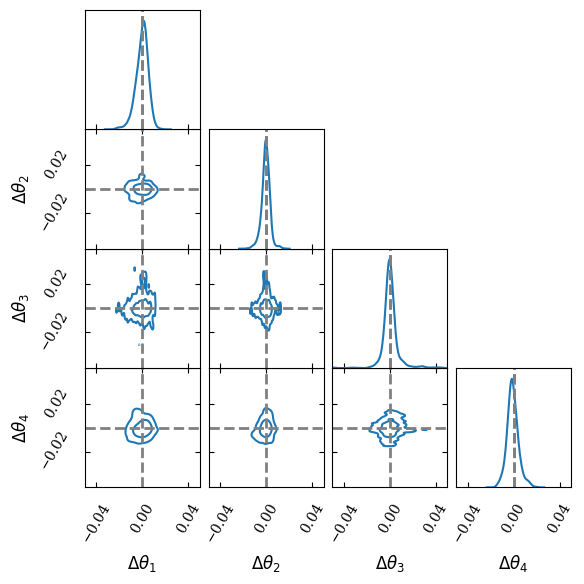

In [18]:
%matplotlib inline
plot_pretty()
rcParams.update({"text.usetex": False})
rcParams['font.family'] = 'serif'

g = plots.get_subplot_plotter(width_inch=6)
g.settings.axes_fontsize=12
g.settings.axis_tick_x_rotation=60
g.settings.axis_tick_y_rotation=60
g.settings.scaling_factor = 1
g.settings.linewidth=2
g.triangle_plot(
    [SBIsamples_plot],
    [r'\theta_1', r'\theta_2', r'\theta_3', r'\theta_4'],
    colors=['tab:blue'],
    line_args=[{'color': 'tab:blue', 'lw': 2}],
    contour_lws=[1.5,1.5],
    markers={
        r'\theta_1': 0, r'\theta_2': 0, r'\theta_3': 0, r'\theta_4': 0
    },
    param_limits = {r'\theta_1':[-0.05,0.05],r'\theta_2':[-0.05,0.05],r'\theta_3':[-0.05,0.05],r'\theta_4':[-.05,.05]},
    marker_args={'lw': 2},
    title_limit=0
)
for i in range(len(g.subplots[0,:])):
  g.subplots[i,i].axvline(color='gray', ls='--', lw=2)
plt.savefig('4param_corner_all.pdf',format='pdf')

/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2029386291.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  samples = np.array(SBI_sample_array[0][index])
/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2029386291.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  logp = np.array(SBI_logp_array[0][index])


Removed no burn in


/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2029386291.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  samples = np.array(SBI_sample_array[0][index])
/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2029386291.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  logp = np.array(SBI_logp_array[0][index])


Removed no burn in


/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2029386291.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  samples = np.array(SBI_sample_array[0][index])
/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2029386291.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  logp = np.array(SBI_logp_array[0][index])


Removed no burn in


/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2029386291.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  samples = np.array(SBI_sample_array[0][index])
/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2029386291.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  logp = np.array(SBI_logp_array[0][index])


Removed no burn in


/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2029386291.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  samples = np.array(SBI_sample_array[0][index])
/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2029386291.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  logp = np.array(SBI_logp_array[0][index])


Removed no burn in


/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2029386291.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  samples = np.array(SBI_sample_array[0][index])
/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2029386291.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  logp = np.array(SBI_logp_array[0][index])


Removed no burn in


/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2029386291.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  samples = np.array(SBI_sample_array[0][index])
/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2029386291.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  logp = np.array(SBI_logp_array[0][index])


Removed no burn in


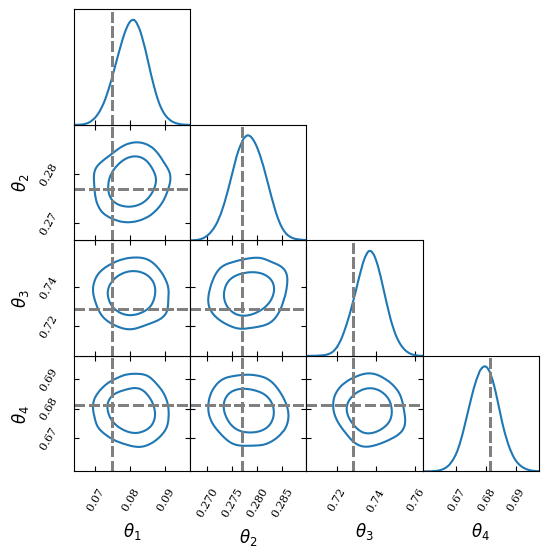

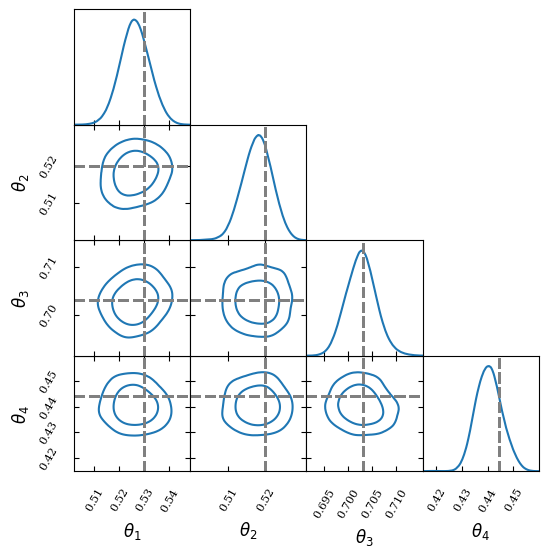

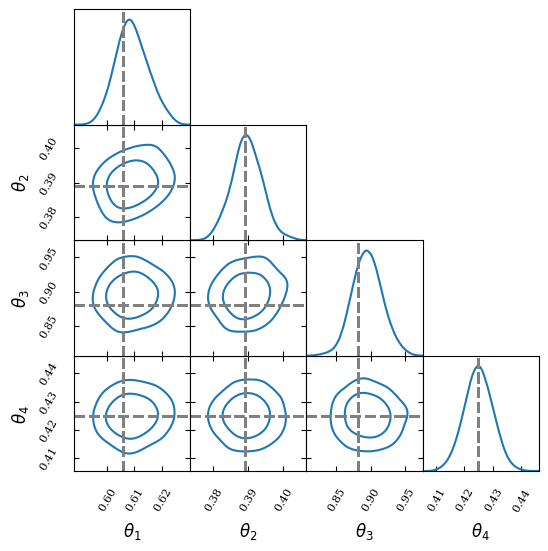

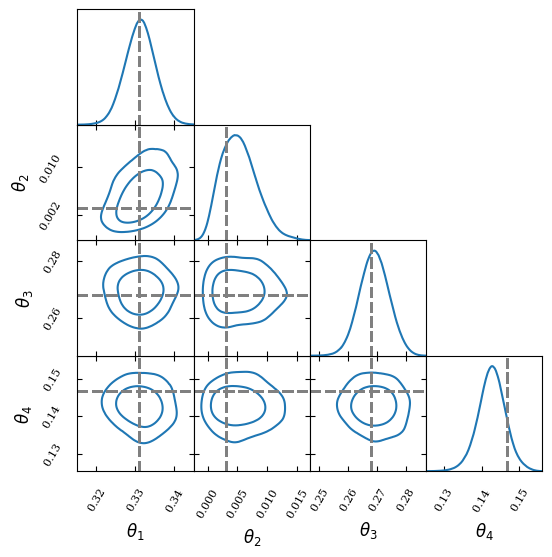

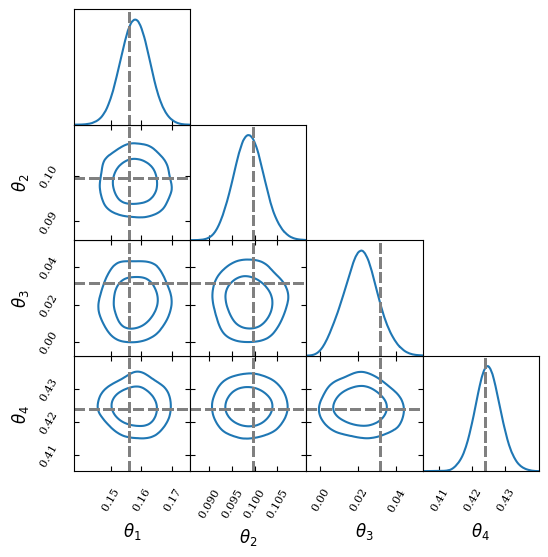

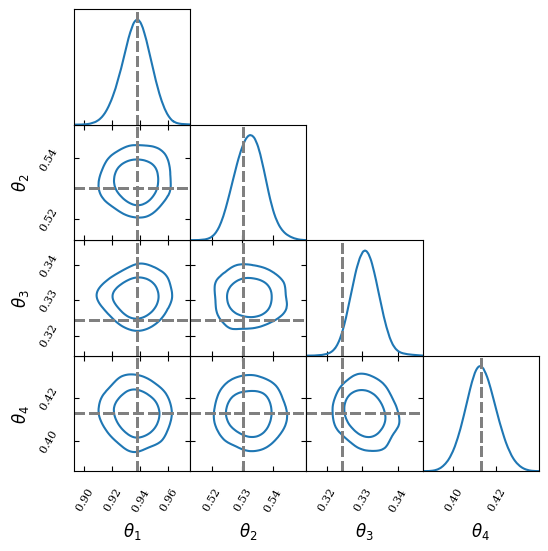

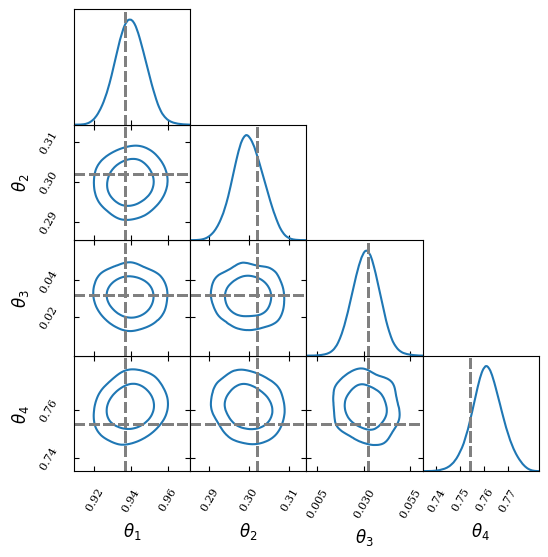

In [19]:
# Corner plots for individual events 


%matplotlib inline
plot_pretty()
rcParams.update({"text.usetex": False})
rcParams['font.family'] = 'serif'

test_number = 1000
prior_low = [min(X1_range), min(X2_range), min(X3_range), min(X4_range)]
prior_high = [max(X1_range), max(X2_range), max(X3_range), max(X4_range)]

limits = np.array([prior_low, prior_high]).T
weird_index = [[0,1,2,3,8,9,10]]

for i, index in enumerate(np.ravel(weird_index[0])):

  theta_1 = [theta_sub[:test_number][index][0] for i in range(test_number)]
  theta_2 = [theta_sub[:test_number][index][1] for i in range(test_number)]
  theta_3 = [theta_sub[:test_number][index][2] for i in range(test_number)]
  theta_4 = [theta_sub[:test_number][index][3] for i in range(test_number)]

  samples = np.array(SBI_sample_array[0][index])
  logp = np.array(SBI_logp_array[0][index])
  best_fit_t = SBI_best_fit_arr[0,index,:]
  max_like_t = SBI_max_like_arr[0,index,:]


  SBIsingle = MCSamples(samples=np.array(samples),
                            names=[
                                r'\theta_1', r'\theta_2', r'\theta_3', r'\theta_4'
                            ],
                            labels=[
                                r'\theta_1', r'\theta_2', r'\theta_3', r'\theta_4'
                            ])


  g = plots.get_subplot_plotter(width_inch=6)
  g.settings.scaling_factor = 1
  g.settings.axes_fontsize=10
  g.settings.axis_tick_x_rotation=60
  g.settings.axis_tick_y_rotation=60
  g.settings.scaling_factor = 1
  g.settings.title_limit_labels = False
  g.settings.title_limit_fontsize = 10
  g.settings.axis_marker_lw = 2
  g.settings.tight_layout = False
  g.settings.constrained_layout = False
  g.triangle_plot([SBIsingle],[r'\theta_1', r'\theta_2', r'\theta_3', r'\theta_4'],
                colors=['tab:blue','tab:orange'],
                contour_lws = [1.5,1.5],
                line_args=[{'color':'tab:blue'},{'color':'tab:orange'}],
                 marker_args ={'lw':2},
                  markers={r'\theta_1':theta_1,r'\theta_2':theta_2, r'\theta_3':theta_3, r'\theta_4':theta_4},
                  title_limit=0)
  plt.savefig('4param_single_image_corner_%s_%s.pdf',format='pdf')

[15.  4.  1.  1.]
[ 0. -2.  0.  0.]
Removed no burn in


/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/4160575835.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  samples = np.array(SBI_sample_array[0][index])


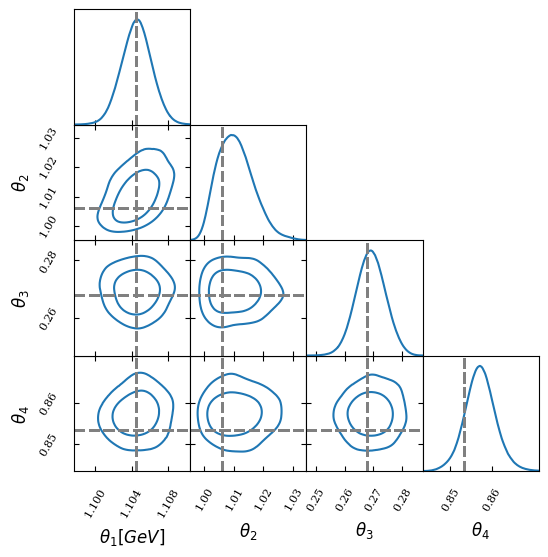

In [20]:
# Plot with index selected for paper

%matplotlib inline
plot_pretty()
rcParams.update({"text.usetex": False})
rcParams['font.family'] = 'serif'

test_number = 1000
prior_low = [min(X1_range), min(X2_range), min(X3_range), min(X4_range)]
prior_high = [max(X1_range), max(X2_range), max(X3_range), max(X4_range)]

limits = np.array([prior_low, prior_high]).T
weird_index = [[3]]

theta_max = np.array([15, 4.0, 1.0, 1.0])
theta_min = np.array([0, -2.0, 0.0, 0])
print(theta_max)
print(theta_min)
 
for i, index in enumerate(np.ravel(weird_index[0])):

  theta_1 = [theta_sub[:test_number][index][0] for i in range(test_number)]
  theta_1= [i * int((theta_max[0] - theta_min[0])) + theta_min[0] for i in theta_1] # original range
  theta_1= [MA * (1 + 0.03 * i) for i in theta_1]   # Physical units

  theta_2 = [theta_sub[:test_number][index][1] for i in range(test_number)]
  theta_2= [i * 4 for i in theta_2]
  theta_2= [1 + 0.5 * i for i in theta_2]
  theta_3 = [theta_sub[:test_number][index][2] for i in range(test_number)]
  theta_3= [i * int((theta_max[2] - theta_min[2])) + theta_min[2] for i in theta_3]
  theta_4 = [theta_sub[:test_number][index][3] for i in range(test_number)]
  theta_4= [i * int((theta_max[3] - theta_min[3])) + theta_min[3] for i in theta_4]
  theta_4= [1 - i for i in theta_4]
  samples = np.array(SBI_sample_array[0][index])

  # Original range
  theta_orig = samples * [15.,  4.,  1.,  1.] #(theta_max - theta_min) + theta_min  

  # Physical quantities
  MaCCQE_samples = MA + 0.03 * MA * theta_orig[:, 0]
  NormCCMEC_samples = 1 + 0.5 * theta_orig[:, 1]
  XSecShape_CCMEC_samples = theta_orig[:, 2]
  RPA_CCQE_samples = 1 - theta_orig[:, 3]

  # Stack the physical observables
  samples_physical = np.vstack([
      MaCCQE_samples,
      NormCCMEC_samples,
      XSecShape_CCMEC_samples,
      RPA_CCQE_samples
   ]).T


  SBIsingle = MCSamples(samples=np.array(samples_physical),
                            names=[
                                r'\theta_1', r'\theta_2', r'\theta_3', r'\theta_4'
                            ],
                            labels=[
                                r'\theta_1[GeV]', r'\theta_2', r'\theta_3', r'\theta_4'
                            ])

  g = plots.get_subplot_plotter(width_inch=6)
  g.settings.scaling_factor = 1
  g.settings.axes_fontsize=10
  g.settings.axis_tick_x_rotation=60
  g.settings.axis_tick_y_rotation=60
  g.settings.scaling_factor = 1
  g.settings.title_limit_labels = False
  g.settings.title_limit_fontsize = 10
  g.settings.axis_marker_lw = 2
  g.settings.tight_layout = False
  g.settings.constrained_layout = False
  g.triangle_plot([SBIsingle],[r'\theta_1', r'\theta_2', r'\theta_3', r'\theta_4'],
                colors=['tab:blue','tab:orange'],
                contour_lws = [1.5,1.5],
                line_args=[{'color':'tab:blue'},{'color':'tab:orange'}],
                 marker_args ={'lw':2},
                  markers={r'\theta_1':theta_1,r'\theta_2':theta_2, r'\theta_3':theta_3, r'\theta_4':theta_4},
                  title_limit=0)
  plt.savefig('4param_single_image_corner.pdf',format='pdf', bbox_inches='tight')

In [21]:
def calculate_coverage_fraction(x_observed, pos_list, truth_array, percentile_list, test_number=100, sample_number = 1000):
  count_array = []
  for i in range(test_number):
    samples = pos_list.set_default_x(x_observed[i]).sample((sample_number,),show_progress_bars=False)
    count_vector = []
    for ind, cov in enumerate(percentile_list):
      percentile_l = 50.0 - cov/2
      percentile_u = 50.0 + cov/2
      confidence_l = np.percentile(samples.cpu(),percentile_l,axis=0)
      confidence_u = np.percentile(samples.cpu(),percentile_u,axis=0)
      count = np.logical_and(confidence_u - truth_array.T[i] > 0, truth_array.T[i] - confidence_l > 0)
      count_vector.append(count)
    count_array.append(count_vector)
  count_sum_array = np.sum(count_array, axis=0)
  frac_lens_within_vol = np.array(count_sum_array)
  return np.array(frac_lens_within_vol).T/sample_number

def distance(param_vector, mean_vector, covariance):
  d = np.array(param_vector-mean_vector)
  return d.dot(covariance).dot(d.T)

def calculate_coverage_fraction_distance_2(x_observed, pos_list, truth_array, percentile_list, covariance, test_number=100, sample_number = 1000):
  count_array = []
  for i in range(test_number):
    samples = pos_list.set_default_x(x_observed[i]).sample((sample_number,),show_progress_bars=False).cpu()
    count_vector = []
    mean = np.median(samples, axis=0)
    for ind, percentile in enumerate(percentile_list):
      d = distance(samples, mean, covariance)
      d_true = distance(truth_array[:,i], mean, covariance)
      d_array = d.diagonal()
      confidence_l = np.percentile(d_array, percentile, axis=0)
      count = confidence_l - d_true > 0
      count_vector.append(count)
    count_array.append(count_vector)
  return np.sum(np.array(count_array), axis=0)/len(samples)

percentile_array = np.linspace(0,100,21)

In [22]:
theta_1 = [theta_sub[:test_number][i][0] for i in range(test_number)]
theta_2 = [theta_sub[:test_number][i][1] for i in range(test_number)]
theta_3 = [theta_sub[:test_number][i][2] for i in range(test_number)]
theta_4 = [theta_sub[:test_number][i][3] for i in range(test_number)]
true_array = np.array([theta_1, theta_2, theta_3, theta_4])
percentile_array = np.linspace(0,100,21)
frac_array = calculate_coverage_fraction(x_t_t, posterior, true_array, percentile_array, test_number)
cov = np.cov(true_array)
frac_array_combined = calculate_coverage_fraction_distance_2(x_observed, posterior, true_array, percentile_array, cov, test_number)


/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2668637048.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  d = np.array(param_vector-mean_vector)
/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/2668637048.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  d = np.array(param_vector-mean_vector)


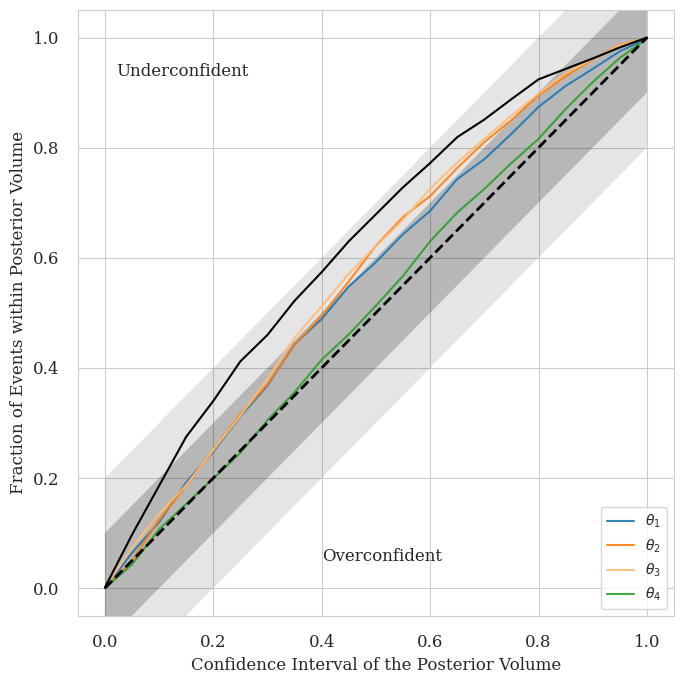

In [23]:
percentile_array = np.linspace(0,100,21)
percentile_array_norm = np.array(percentile_array)/100

from cycler import cycler

# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (140, 86, 75),
             (227, 119, 194), (23, 190, 207), (158, 218, 229)]


# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

default_cycler = (cycler(color=tableau20[:10]) + cycler(linestyle=['-','-','-','-',':',':','--','--','--','--']))

plt.rc('lines', linewidth=1.5)
plt.rc('axes', prop_cycle=default_cycler)

sns.set_style("whitegrid")
rcParams.update({"text.usetex": False})
rcParams['font.family'] = 'serif'

fig, ax = plt.subplots(1,1,figsize=(7,7))
plt.plot(percentile_array_norm, frac_array.T, alpha = .9)
plt.plot(percentile_array_norm, frac_array_combined, c = 'k',ls='-')
plt.plot([0,0.5,1],[0,0.5,1], 'k--', lw=2, zorder=1000)
plt.fill_between(
    x=percentile_array_norm,
    y1=percentile_array_norm-0.1,
    y2=percentile_array_norm+0.1,
    color='k',
    edgecolor="none",
    alpha=0.2,)
plt.fill_between(
    x=percentile_array_norm,
    y1=percentile_array_norm-0.2,
    y2=percentile_array_norm+0.2,
    color='k',
    edgecolor="none",
    alpha=0.1,)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.text(0.02,0.93,'Underconfident', fontsize=12, horizontalalignment='left')
plt.text(0.4,0.05,'Overconfident',fontsize =12, horizontalalignment='left')
plt.legend([r'$\theta_1$', r'$\theta_2$', r'$\theta_3$', r'$\theta_4$'], prop={'size': 10}, ncol=1, loc=4)
plt.xlabel('Confidence Interval of the Posterior Volume')
plt.ylabel('Fraction of Events within Posterior Volume')
# plt.title(f'NPE')
plt.tight_layout()
plt.savefig(f'4_param_npe_pos_v2.pdf', format='pdf')

## Testing with T2K Data

In [24]:
# file='my_data_hists_out.txt'
file="ub_tune_hist_out.txt"
with open(file, mode="r") as file:
    param_t2k = list(csv.reader(file))
x_t2k = []
numbers_ar_t2k=[]
for i in range(len(param_t2k)):
    numbers_t2k = re.findall(r'[-+]?\d*\.\d+e[+-]?\d+|\d+\.\d+|\d+', param_t2k[i][0])
    numbers_array_t2k = [float(num) for num in numbers_t2k]
    numbers_ar_t2k.append(numbers_array_t2k)
    x_t2k.append(numbers_array_t2k)

In [25]:
y_t2k_0 = torch.mean(posterior.sample((100,), x=x_t2k[0]/ x_sub.max().detach().numpy()), axis=0)
print(y_t2k_0)

124it [00:00, 14728.11it/s]            

tensor([0.3315, 0.3284, 0.9959, 0.1483])


In [26]:
array_dump_t2k = make_summary_statistic_array(x_t2k, posterior, 1)

SBI_sample_array_t2k, SBI_logp_array_t2k, SBI_map_array_t2k, SBI_best_fit_arr_t2k, \
SBI_max_like_arr_t2k, SBI_percentile68u_arr_t2k, SBI_percentile68l_arr_t2k, \
SBI_percentile95u_arr_t2k, SBI_percentile95l_arr_t2k = array_dump_t2k

SBI_error_1sigma_t2k = SBI_percentile68u_arr_t2k - SBI_percentile68l_arr_t2k
mean_sigma_1_errors_t2k = SBI_error_1sigma_t2k.mean(axis=1)
print(mean_sigma_1_errors_t2k.squeeze())


0


1071it [00:00, 7019.96it/s]                         

[0.01089114 0.01874655 0.04745299 0.027156  ]


In [27]:
print("Test samples average: ", SBI_best_fit_arr_t2k.mean(axis=1)[0])
print("central value: ", y_t2k_0)

Test samples average:  [0.9945992  0.9775304  0.65981114 0.8836783 ]
central value:  tensor([0.3315, 0.3284, 0.9959, 0.1483])


/var/folders/ps/lzncg4g56n9dr7rsdpq6fpzw0000j6/T/ipykernel_33898/3591152320.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  theta_original = y_normalized * (theta_max - theta_min) + theta_min


[14.9999    3.99997   0.999996  0.999995]
[ 7.08690e-05 -8.20886e-05  4.38304e-06 -9.80890e-05]
central value original units:  tensor([0.3315, 0.3284, 0.9959, 0.1483])
central value GENIE units:  tensor([4.9724, 1.3134, 0.9959, 0.1483])


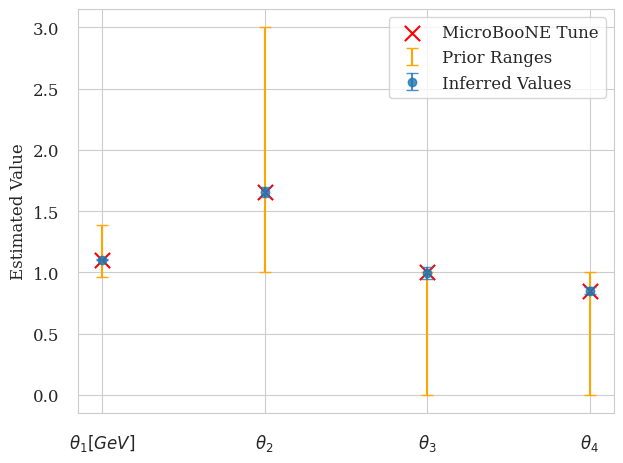

In [28]:
theta_labels = [r'$\theta_1 [GeV]$', r'$\theta_2$', r'$\theta_3$', r'$\theta_4$']
x = np.arange(len(theta_labels))

# MicroBooNE physics truth values
reference_y = np.array([1.10, 1.66, 1.0, 0.85])
# 1sigma uncertainties
reference_yerr_asym = np.array([
    [0.10, 0.5, 1.0, 0.4],   # lower errors MicroBoonE
    [0.10, 0.5, 0.0, 0.4]    # upper errors MicroBoonE
])

# Recovering GENIE units 

theta_max = np.array([theta_or[:,0].max(), theta_or[:,1].max(), theta_or[:,2].max(), theta_or[:,3].max()])
theta_min = np.array([theta_or[:,0].min(), theta_or[:,1].min(), theta_or[:,2].min(), theta_or[:,3].min()])
print(theta_max)
print(theta_min)

y_normalized = y_t2k_0
yerr_normalized = mean_sigma_1_errors_t2k.squeeze()

# Reverse normalization [0,1] to original range
theta_original = y_normalized * (theta_max - theta_min) + theta_min
print("central value original units: ", y_t2k_0)
print("central value GENIE units: ", theta_original)
theta_errors = yerr_normalized * (theta_max - theta_min)


# Change to physical units

y_physical = np.array([
    MA * (1 + 0.03 * theta_original[0]),        
    1 + (0.5 * theta_original[1]),                
    theta_original[2],                          
    1 - theta_original[3]     
])

# Error propagation
yerr_physical = np.array([
    MA * 0.03 * theta_errors[0],                
    0.5 * theta_errors[1],                      
    theta_errors[2],                            
    theta_errors[3]                             
])


# Prior ranges
prior_ranges = np.array([
    [0.961, 1, 0, 0],  
    [1.39, 3, 1, 1]    
])
# Compute asymmetric errors for errorbar
prior_lower = y_physical - prior_ranges[0]
prior_upper = prior_ranges[1] - y_physical

# Combine into shape (2, N)
prior_errors = np.vstack([prior_lower, prior_upper])

plt.errorbar(x, y_physical  , yerr=prior_errors, fmt=' ', capsize=4, label='Prior Ranges ', color='orange')
plt.scatter(x, reference_y, marker='x', color='red', s=120, label='MicroBooNE Tune', alpha=1)
plt.errorbar(x, y_physical  , yerr=yerr_physical, fmt='o', capsize=4, label='Inferred Values ', alpha=.8)
# plt.errorbar(x, reference_y, yerr=reference_yerr_asym, fmt='o', capsize=4, color='red', label='MicroBooNE', alpha=0.4)


plt.xticks(x, theta_labels)
plt.ylabel('Estimated Value')
# plt.title('Posterior Mean ± 1σ Error (Physical Units)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Posterior_errors_physical_with_truth.pdf", format="pdf", bbox_inches='tight')
plt.show()